In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install sastrawi

     |████████████████████████████████| 215kB 2.8MB/s 


In [ ]:
import numpy as np
import pandas as pd
import os
import collections
import re
import string
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek


import keras
from keras import backend as K
from keras import regularizers
from keras.models import Sequential, Model, load_model
from keras.layers import Input, InputLayer, Embedding, Dense, Add, Concatenate, ZeroPadding1D, Dropout, SpatialDropout1D, Activation
from keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPool1D, AveragePooling1D, BatchNormalization, Flatten, SimpleRNN, Bidirectional, concatenate
from keras.layers.recurrent import LSTM, GRU
from keras.optimizers import Adam, SGD, Adagrad, Adadelta, RMSprop, Nadam
from keras.losses import categorical_crossentropy
from keras.layers.normalization import BatchNormalization
from keras.preprocessing import text, sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint, ReduceLROnPlateau
from keras.utils.vis_utils import plot_model
from keras.utils import np_utils

import matplotlib.pyplot as plt

from gensim.models.wrappers import FastText
from gensim.models import Word2Vec, KeyedVectors

In [ ]:
maranatha_df = pd.read_excel('/content/drive/My Drive/Colab Notebooks/MARANATHAv2_filtered_index.xls')
marnath_df = pd.read_excel('/content/drive/My Drive/Colab Notebooks/MARNATHv2_filtered_index.xls')
marnat_df = pd.read_excel('/content/drive/My Drive/Colab Notebooks/MARNATv2_filtered_index.xls')

In [ ]:
data = [maranatha_df, marnath_df, marnat_df]
join_df = pd.concat(data)
join_df.drop_duplicates()
join_df.reset_index(drop=True, inplace=True)
join_df.dropna(inplace=True)
join_df.sort_values(by='Datetime', ascending=False)
join_df['Sentiment'] = join_df.Sentiment.map({9:0, 0:0, 1:1, -1:-1})
join_df['Sentiment'] = join_df.Sentiment.map({0:'Neutral', 1:'Positive', -1:'Negative'})
join_df

,Datetime,Text,Sentiment
0,2019-12-30 17:41:29+00:00,Ini ketika di Maranatha Bandung bulan Juli kem...,Neutral
1,2019-12-30 17:09:36+00:00,yakin anak maranatha tidak ada yang main twitter,Neutral
2,2019-12-30 16:20:08+00:00,Ini waktu pertama temu sama di angkringan mara...,Neutral
3,2019-12-30 15:52:50+00:00,telkom unpar maranatha tau itu saja bandung wkwkw,Positive
4,2019-12-30 14:25:56+00:00,mohon maaf baru balas. . ini pergelaran juli l...,Positive
...,...,...,...
5362,2018-01-13 04:31:00+00:00,Dan hasil keluar sama marnat dan dua aku terim...,Neutral
5363,2018-01-10 15:00:03+00:00,Bandung tau aku Unpar hi / arsitektur Unisba i...,Positive
5364,2018-01-07 15:13:59+00:00,"untuk yang mau ambil hukum di unpar, hukum unp...",Neutral
5365,2018-01-07 07:42:38+00:00,Semoga jadi dosen di marnat supaya tidak enak,Neutral


In [ ]:
factorystemmer = StemmerFactory()
stemmer = factorystemmer.create_stemmer()

factorystop = StopWordRemoverFactory()
stopwords = factorystop.create_stop_word_remover()

def clean_text(text):
    text = text.lower() #ubah text menjadi lower case
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text) #hapus tanda baca
    text = re.sub('[‘’“”…]', '', text) #hapus tanda baca lain
    text = re.sub('[0-9]+', '', text) #hapus angka
    text = re.sub('(?:a{0,2}h{1,2}a{0,2}){2,}h?', '', text) #hapus haha-ahah pattern
    text = re.sub('(?:e{0,2}h{1,2}e{0,2}){2,}h?', '', text) #hapus hehe-eheh pattern
    text = re.sub('(?:i{0,2}h{1,2}i{0,2}){2,}h?', '', text) #hapus hihi-ihih pattern
    text = re.sub(r'\b[wk]*(?:wk|kw)[wk]*\b', '', text) #hapus wkwk-kwkw pattern
    text = re.sub(r'\s—\s', '', text) #hapus spasi berlebih
    text = re.sub(r'http\S+', '', text) #hapus link
    text = ''.join([i for i in text if not i.isdigit()]) # Remove digits
    #text = re.sub('maranatha', '', text) #hapus keyword input maranatha
    #text = re.sub('marnath', '', text) #hapus keyword input marnath
    #text = re.sub('marnat', '', text) #hapus keyword input marnat
    text = stemmer.stem(text) #stemming
    text = stopwords.remove(text) #hapus stopwords
    return text

In [ ]:
%%time

text_cleaner = []

for text in join_df.Text:
    text_cleaner.append(clean_text(text))

CPU times: user 6min 52s, sys: 67.9 ms, total: 6min 52s
Wall time: 6min 53s


In [ ]:
new_text = pd.DataFrame({'New_Text' : text_cleaner})
clean_df = pd.concat([join_df, new_text], axis = 1)
clean_df.replace('', np.nan, inplace=True)
clean_df.dropna(inplace=True)
clean_df.reset_index(drop=True, inplace=True)
clean_df

,Datetime,Text,Sentiment,New_Text
0,2019-12-30 17:41:29+00:00,Ini ketika di Maranatha Bandung bulan Juli kem...,Neutral,ketika maranatha bandung bulan juli kemarin di...
1,2019-12-30 17:09:36+00:00,yakin anak maranatha tidak ada yang main twitter,Neutral,yakin anak maranatha ada main twitter
2,2019-12-30 16:20:08+00:00,Ini waktu pertama temu sama di angkringan mara...,Neutral,waktu pertama temu sama angkring maranatha
3,2019-12-30 15:52:50+00:00,telkom unpar maranatha tau itu saja bandung wkwkw,Positive,telkom unpar maranatha tau saja bandung
4,2019-12-30 14:25:56+00:00,mohon maaf baru balas. . ini pergelaran juli l...,Positive,mohon maaf baru balas gelar juli lalu gelar wa...
...,...,...,...,...
5362,2018-01-13 04:31:00+00:00,Dan hasil keluar sama marnat dan dua aku terim...,Neutral,hasil keluar sama marnat dua aku terima aku ta...
5363,2018-01-10 15:00:03+00:00,Bandung tau aku Unpar hi / arsitektur Unisba i...,Positive,bandung tau aku unpar hi arsitektur unisba ilk...
5364,2018-01-07 15:13:59+00:00,"untuk yang mau ambil hukum di unpar, hukum unp...",Neutral,yang mau ambil hukum unpar hukum unpar jurus y...
5365,2018-01-07 07:42:38+00:00,Semoga jadi dosen di marnat supaya tidak enak,Neutral,moga jadi dosen marnat tidak enak


In [ ]:
def clean_text_token(text):
    text = re.sub(r'[^\w\d\s]+', '', text) # Remove punctuation
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text) #hapus tanda baca
    text = re.sub('[‘’“”…]', '', text) #hapus tanda baca lain
    text = re.sub('[0-9]+', '', text) #hapus angka
    text = re.sub('(?:a{0,2}h{1,2}a{0,2}){2,}h?', '', text) #hapus haha-ahah pattern
    text = re.sub('(?:e{0,2}h{1,2}e{0,2}){2,}h?', '', text) #hapus hehe-eheh pattern
    text = re.sub('(?:i{0,2}h{1,2}i{0,2}){2,}h?', '', text) #hapus hihi-ihih pattern
    text = re.sub(r'\b[wk]*(?:wk|kw)[wk]*\b', '', text) #hapus wkwk-kwkw pattern
    text = re.sub(r'\s—\s', '', text) #hapus spasi berlebih
    text = re.sub(r'http\S+', '', text) #hapus link
    text = ''.join([i for i in text if not i.isdigit()]) # Remove digits
    text = stemmer.stem(text) #stemming
    text = stopwords.remove(text) #hapus stopwords
    text = text.split()
    return text

clean_df['Tokenize'] = clean_df['Text'].apply(lambda x: clean_text_token(x))

In [ ]:
clean_df

,Datetime,Text,Sentiment,New_Text,Tokenize
0,2019-12-30 17:41:29+00:00,Ini ketika di Maranatha Bandung bulan Juli kem...,Neutral,ketika maranatha bandung bulan juli kemarin di...,"[ketika, maranatha, bandung, bulan, juli, kema..."
1,2019-12-30 17:09:36+00:00,yakin anak maranatha tidak ada yang main twitter,Neutral,yakin anak maranatha ada main twitter,"[yakin, anak, maranatha, ada, main, twitter]"
2,2019-12-30 16:20:08+00:00,Ini waktu pertama temu sama di angkringan mara...,Neutral,waktu pertama temu sama angkring maranatha,"[waktu, pertama, temu, sama, angkring, maranatha]"
3,2019-12-30 15:52:50+00:00,telkom unpar maranatha tau itu saja bandung wkwkw,Positive,telkom unpar maranatha tau saja bandung,"[telkom, unpar, maranatha, tau, saja, bandung]"
4,2019-12-30 14:25:56+00:00,mohon maaf baru balas. . ini pergelaran juli l...,Positive,mohon maaf baru balas gelar juli lalu gelar wa...,"[mohon, maaf, baru, balas, gelar, juli, lalu, ..."
...,...,...,...,...,...
5362,2018-01-13 04:31:00+00:00,Dan hasil keluar sama marnat dan dua aku terim...,Neutral,hasil keluar sama marnat dua aku terima aku ta...,"[hasil, keluar, sama, marnat, dua, aku, terima..."
5363,2018-01-10 15:00:03+00:00,Bandung tau aku Unpar hi / arsitektur Unisba i...,Positive,bandung tau aku unpar hi arsitektur unisba ilk...,"[bandung, tau, aku, unpar, hi, arsitektur, uni..."
5364,2018-01-07 15:13:59+00:00,"untuk yang mau ambil hukum di unpar, hukum unp...",Neutral,yang mau ambil hukum unpar hukum unpar jurus y...,"[yang, mau, ambil, hukum, unpar, hukum, unpar,..."
5365,2018-01-07 07:42:38+00:00,Semoga jadi dosen di marnat supaya tidak enak,Neutral,moga jadi dosen marnat tidak enak,"[moga, jadi, dosen, marnat, tidak, enak]"


In [ ]:
#clean_df.to_excel('tesis_clean_df.xls', index=False)

In [ ]:
data = clean_df[['New_Text', 'Sentiment', 'Tokenize']]

In [ ]:
data.head(25)

,New_Text,Sentiment,Tokenize
0,ketika maranatha bandung bulan juli kemarin di...,Neutral,"[ketika, maranatha, bandung, bulan, juli, kema..."
1,yakin anak maranatha ada main twitter,Neutral,"[yakin, anak, maranatha, ada, main, twitter]"
2,waktu pertama temu sama angkring maranatha,Neutral,"[waktu, pertama, temu, sama, angkring, maranatha]"
3,telkom unpar maranatha tau saja bandung,Positive,"[telkom, unpar, maranatha, tau, saja, bandung]"
4,mohon maaf baru balas gelar juli lalu gelar wa...,Positive,"[mohon, maaf, baru, balas, gelar, juli, lalu, ..."
5,iya juga mahasiswa universitas maranatha jurus...,Neutral,"[iya, juga, mahasiswa, universitas, maranatha,..."
6,regu alumni maranatha,Positive,"[regu, alumni, maranatha]"
7,unjani maranatha bhakti kencana kalau salah un...,Positive,"[unjani, maranatha, bhakti, kencana, kalau, sa..."
8,teman aku maranatha,Neutral,"[teman, aku, maranatha]"
9,teman aku maranatha bandung fakultas dokter gigi,Positive,"[teman, aku, maranatha, bandung, fakultas, dok..."


### **Multinomial Naive Bayes**

In [ ]:
tvec3 = TfidfVectorizer(ngram_range=(1, 3)) #tfidf trigram
cvec3 = CountVectorizer(ngram_range=(1, 3))
mnb = MultinomialNB()
cnb = ComplementNB()

#### Pipeline

In [ ]:
#MultinomialNB classifier
def mnb_cv(splits, X, Y, pipeline, average_method):
    
    kfoldmnb = StratifiedKFold(n_splits=splits, shuffle=True, random_state=5)
    #accuracymnb = []
    precisionmnb = []
    recallmnb = []
    f1mnb = []
    for train, test in kfoldmnb.split(X, Y):
        mnb_fit = pipeline.fit(X[train], Y[train])
        predictionmnb = mnb_fit.predict(X[test])
        scoresmnb = mnb_fit.score(X[test],Y[test])
        class_names = ['Negative','Neutral','Positive']
        cm = confusion_matrix((Y[test]), predictionmnb)
        mnbdf_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
        
    
        #accuracymnb.append(scoresmnb * 100)
        #print('Accuracy: ', scoresmnb * 100)
        precisionmnb.append(precision_score(Y[test], predictionmnb, average=average_method)*100)
        print(' '*10, class_names)
        print('Precision:',precision_score(Y[test], predictionmnb, average=None))
        recallmnb.append(recall_score(Y[test], predictionmnb, average=average_method)*100)
        print('Recall:   ',recall_score(Y[test], predictionmnb, average=None))
        f1mnb.append(f1_score(Y[test], predictionmnb, average=average_method)*100)
        print('F1 score: ',f1_score(Y[test], predictionmnb, average=None))
        print('-'*50)

        #mnbaccumean = np.mean(accuracymnb)
        mnbprecmean = np.mean(precisionmnb)
        mnbrecamean = np.mean(recallmnb)
        mnbf1scmean = np.mean(f1mnb)
            
    #print('Accuracy: %.2f%% (+/- %.2f%%)' % (mnbaccumean, np.std(accuracymnb)))
    print('Precision: %.2f%% (+/- %.2f%%)' % (mnbprecmean, np.std(precisionmnb)))
    print('Recall: %.2f%% (+/- %.2f%%)' % (mnbrecamean, np.std(recallmnb)))
    print('F1 score: %.2f%% (+/- %.2f%%)' % (mnbf1scmean, np.std(f1mnb)))
    print(' ')
    print('Confusion matrix\n', mnbdf_cm)
    return kfoldmnb, precisionmnb, recallmnb, f1mnb

In [ ]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [ ]:
# Resampling Over Sampling
ROSnb = RandomOverSampler(sampling_strategy='not majority', random_state=5)
SMOTEnb = SMOTE(sampling_strategy='not majority', random_state=5)

# Resampling Under Sampling
RUSnb = RandomUnderSampler(sampling_strategy='not minority', random_state=5)
TOMnb = TomekLinks(sampling_strategy='majority')

# Resampling SMOTETomek
SMOTETomnb = SMOTETomek(random_state=5, 
                       smote=SMOTE(sampling_strategy='not majority', random_state=5), 
                       tomek=TomekLinks(sampling_strategy='majority')
                        )

In [ ]:
mnb_SMOTETOM_tvec3_pipeline = make_pipeline(tvec3, SMOTETomnb, mnb) #trigram

In [ ]:
mnbsmotetomtvec3 = mnb_cv(10, data.New_Text, data.Sentiment, mnb_SMOTETOM_tvec3_pipeline, 'macro')

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


           ['Negative', 'Neutral', 'Positive']
Precision: [0.27586207 0.85964912 0.43382353]
Recall:    [0.65306122 0.62659847 0.60824742]
F1 score:  [0.38787879 0.72485207 0.50643777]
--------------------------------------------------


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


           ['Negative', 'Neutral', 'Positive']
Precision: [0.25471698 0.87234043 0.44295302]
Recall:    [0.55102041 0.62915601 0.68041237]
F1 score:  [0.3483871  0.73105498 0.53658537]
--------------------------------------------------


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


           ['Negative', 'Neutral', 'Positive']
Precision: [0.25490196 0.89160839 0.51006711]
Recall:    [0.53061224 0.65217391 0.78350515]
F1 score:  [0.34437086 0.75332349 0.61788618]
--------------------------------------------------


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


           ['Negative', 'Neutral', 'Positive']
Precision: [0.26956522 0.88235294 0.4       ]
Recall:    [0.63265306 0.61381074 0.6185567 ]
F1 score:  [0.37804878 0.7239819  0.48582996]
--------------------------------------------------


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


           ['Negative', 'Neutral', 'Positive']
Precision: [0.24545455 0.87769784 0.44295302]
Recall:    [0.55102041 0.62404092 0.68041237]
F1 score:  [0.33962264 0.72944694 0.53658537]
--------------------------------------------------


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


           ['Negative', 'Neutral', 'Positive']
Precision: [0.30927835 0.87412587 0.42207792]
Recall:    [0.6122449  0.63938619 0.67010309]
F1 score:  [0.4109589  0.73855244 0.51792829]
--------------------------------------------------


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


           ['Negative', 'Neutral', 'Positive']
Precision: [0.28099174 0.86868687 0.46218487]
Recall:    [0.68       0.66153846 0.56701031]
F1 score:  [0.39766082 0.7510917  0.50925926]
--------------------------------------------------


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


           ['Negative', 'Neutral', 'Positive']
Precision: [0.31313131 0.88552189 0.46428571]
Recall:    [0.63265306 0.67435897 0.67010309]
F1 score:  [0.41891892 0.76564774 0.54852321]
--------------------------------------------------


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


           ['Negative', 'Neutral', 'Positive']
Precision: [0.24193548 0.88043478 0.45588235]
Recall:    [0.6122449  0.62307692 0.63917526]
F1 score:  [0.34682081 0.72972973 0.53218884]
--------------------------------------------------


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


           ['Negative', 'Neutral', 'Positive']
Precision: [0.27272727 0.87719298 0.43421053]
Recall:    [0.55102041 0.64102564 0.68041237]
F1 score:  [0.36486486 0.74074074 0.53012048]
--------------------------------------------------
Precision: 53.19% (+/- 1.21%)
Recall: 63.30% (+/- 1.38%)
F1 score: 54.82% (+/- 1.53%)
 
Confusion matrix
           Negative  Neutral  Positive
Negative        27       16         6
Neutral         60      250        80
Positive        12       19        66


#### Non Pipeline

In [ ]:
X = data.New_Text
Y = data.Sentiment

In [ ]:
xtrain, xtest, ytrain, ytest = train_test_split(X, Y, shuffle=True, random_state = 5, stratify = Y)

In [ ]:
xtraintvec = tvec3.fit_transform(xtrain)

In [ ]:
xres, yres = SMOTETomnb.fit_resample(xtraintvec, ytrain)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
xres.shape, yres.shape, xtest.shape, ytest.shape

((8787, 60917), (8787,), (1342,), (1342,))

In [ ]:
pos_weight = len([s for s in yresskf if s=='Positive'])
neg_weight = len([s for s in yresskf if s=='Negative'])
neu_weight = len([s for s in yresskf if s=='Neutral'])
print('Hasil SMOTETomek pada train data label positive: %s' %(pos_weight))
print('Hasil SMOTETomek pada train data label neutral: %s' %(neu_weight))
print('Hasil SMOTETomek pada train data label negative: %s' %(neg_weight))

Hasil SMOTETomek pada train data label positive: 3125
Hasil SMOTETomek pada train data label neutral: 3125
Hasil SMOTETomek pada train data label negative: 3125


In [ ]:
pos_weight = len([s for s in ytest if s=='Positive'])
neg_weight = len([s for s in ytest if s=='Negative'])
neu_weight = len([s for s in ytest if s=='Neutral'])
print(pos_weight)
print(neg_weight)
print(neu_weight)

242
123
965


In [ ]:
xtesttvec = tvec3.transform(xtest)
mnb.fit(xres, yres)
preds = mnb.predict(xtesttvec)

In [ ]:
score = mnb.score(xtesttvec, ytest)

In [ ]:
print(classification_report(ytest, preds))

              precision    recall  f1-score   support

    Negative       0.26      0.65      0.37       123
     Neutral       0.86      0.60      0.71       965
    Positive       0.45      0.64      0.52       242

    accuracy                           0.61      1330
   macro avg       0.52      0.63      0.53      1330
weighted avg       0.73      0.61      0.64      1330



In [ ]:
class_names = ['Negative','Neutral','Positive']

print(' '*10, class_names)
print('Precision:',precision_score(ytest, preds, average=None))
print('Recall:   ',recall_score(ytest, preds, average=None))
print('F1 score: ',f1_score(ytest, preds, average=None))
print(' '*10)
print('Precision: %.2f%% (+/- %.2f%%)' % (np.mean(precision_score(ytest, preds, average=None)*100), np.std(precision_score(ytest, preds, average=None))))
print('Recall: %.2f%% (+/- %.2f%%)' % (np.mean(recall_score(ytest, preds, average=None)*100), np.std(recall_score(ytest, preds, average=None))))
print('F1 score: %.2f%% (+/- %.2f%%)' % (np.mean(f1_score(ytest, preds, average=None)*100), np.std(f1_score(ytest, preds, average=None))))

           ['Negative', 'Neutral', 'Positive']
Precision: [0.25889968 0.85798817 0.44637681]
Recall:    [0.6504065  0.60103627 0.63636364]
F1 score:  [0.37037037 0.70688605 0.52470187]
          
Precision: 52.11% (+/- 0.25%)
Recall: 62.93% (+/- 0.02%)
F1 score: 53.40% (+/- 0.14%)


In [ ]:
mnbcm = confusion_matrix((ytest), preds)
mnbcm_df = pd.DataFrame(mnbcm, index=class_names, columns=class_names)
print('Confusion matrix\n', mnbcm_df)

Confusion matrix
           Negative  Neutral  Positive
Negative        80       35         8
Neutral        202      580       183
Positive        27       61       154


##### Non Pipeline Stritified KFold ver

###### X = Tokenize

In [ ]:
#X = data.Tokenize
#X = [str (item) for item in X]
#X = np.array(X)
#Y = data.Sentiment

In [ ]:
#X

array(["['ketika', 'maranatha', 'bandung', 'bulan', 'juli', 'kemarin', 'di', 'culik', 'tabuh']",
       "['yakin', 'anak', 'maranatha', 'ada', 'main', 'twitter']",
       "['waktu', 'pertama', 'temu', 'sama', 'angkring', 'maranatha']",
       ...,
       "['yang', 'mau', 'ambil', 'hukum', 'unpar', 'hukum', 'unpar', 'jurus', 'yang', 'ada', 'jurus', 'aku', 'tau', 'atmajaya', 'pancasila', 'marnat', 'di', 'guru', 'tinggi', 'negeri', 'aku', 'tau']",
       "['moga', 'jadi', 'dosen', 'marnat', 'tidak', 'enak']",
       "['foto', 'saja', 'asa', 'kesan', 'anak', 'manajemen', 'bisnis', 'marnat', 'sedang', 'selesai', 'presentasi', 'langsung', 'pergi', 'braga']"],
      dtype='<U431')

###### Stritified KFold

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)

accuracymnbskf = []
precisionmnbskf = []
recallmnbskf = []
f1mnbskf = []
for train_skf, test_skf in skf.split(X, Y):
  xtraintvecskf = tvec3.fit_transform(X[train_skf])
  xtesttvecskf = tvec3.transform(X[test_skf])
  xresskf, yresskf = SMOTETomnb.fit_resample(xtraintvecskf, Y[train_skf])
  mnb_fitskf = mnb.fit(xresskf, yresskf)
  predictionmnbskf = mnb_fitskf.predict(xtesttvecskf)
  scoresmnbskf = mnb_fitskf.score(xtesttvecskf, Y[test_skf])
  class_names_skf = ['Negative','Neutral','Positive']
  cmskf = confusion_matrix((Y[test_skf]), predictionmnbskf)
  mnbdf_cmskf = pd.DataFrame(cmskf, index=class_names_skf, columns=class_names_skf)

  print(' '*10)
  accuracymnbskf.append(scoresmnbskf * 100)
  print('Accuracy: ', scoresmnbskf * 100)
  print(' '*10, class_names_skf)
  precisionmnbskf.append(precision_score(Y[test_skf], predictionmnbskf, average='macro')*100)
  print('Precision:',precision_score(Y[test_skf], predictionmnbskf, average=None))
  recallmnbskf.append(recall_score(Y[test_skf], predictionmnbskf, average='macro')*100)
  print('Recall:   ',recall_score(Y[test_skf], predictionmnbskf, average=None))
  f1mnbskf.append(f1_score(Y[test_skf], predictionmnbskf, average='macro')*100)
  print('F1 score: ',f1_score(Y[test_skf], predictionmnbskf, average=None))
  print('-'*50)
  print('Precision: %.2f%% (+/- %.2f%%)' % (np.mean(precision_score(Y[test_skf], predictionmnbskf, average=None)*100), 
                                            np.std(precision_score(Y[test_skf], predictionmnbskf, average=None))))
  print('Recall: %.2f%% (+/- %.2f%%)' % (np.mean(recall_score(Y[test_skf], predictionmnbskf, average=None)*100), 
                                         np.std(recall_score(Y[test_skf], predictionmnbskf, average=None))))
  print('F1 score: %.2f%% (+/- %.2f%%)' % (np.mean(f1_score(Y[test_skf], predictionmnbskf, average=None)*100), 
                                           np.std(f1_score(Y[test_skf], predictionmnbskf, average=None))))
  print('Confusion matrix\n', mnbdf_cmskf)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


          
Accuracy:  62.290502793296085
           ['Negative', 'Neutral', 'Positive']
Precision: [0.2605042  0.87613843 0.43902439]
Recall:    [0.63265306 0.61508951 0.64948454]
F1 score:  [0.36904762 0.72276484 0.52390852]
--------------------------------------------------
Precision: 52.52% (+/- 0.26%)
Recall: 63.24% (+/- 0.01%)
F1 score: 53.86% (+/- 0.14%)
Confusion matrix
           Negative  Neutral  Positive
Negative        62       26        10
Neutral        150      481       151
Positive        26       42       126


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


          
Accuracy:  63.50093109869647
           ['Negative', 'Neutral', 'Positive']
Precision: [0.24186047 0.87676056 0.45360825]
Recall:    [0.52525253 0.63764405 0.68041237]
F1 score:  [0.33121019 0.73832468 0.5443299 ]
--------------------------------------------------
Precision: 52.41% (+/- 0.26%)
Recall: 61.44% (+/- 0.07%)
F1 score: 53.80% (+/- 0.17%)
Confusion matrix
           Negative  Neutral  Positive
Negative        52       31        16
Neutral        140      498       143
Positive        23       39       132


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


          
Accuracy:  65.05125815470643
           ['Negative', 'Neutral', 'Positive']
Precision: [0.29015544 0.8791019  0.44186047]
Recall:    [0.57142857 0.65172855 0.68556701]
F1 score:  [0.38487973 0.74852941 0.53737374]
--------------------------------------------------
Precision: 53.70% (+/- 0.25%)
Recall: 63.62% (+/- 0.05%)
F1 score: 55.69% (+/- 0.15%)
Confusion matrix
           Negative  Neutral  Positive
Negative        56       30        12
Neutral        116      509       156
Positive        21       40       133


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


          
Accuracy:  64.6784715750233
           ['Negative', 'Neutral', 'Positive']
Precision: [0.30136986 0.875      0.43333333]
Recall:    [0.67346939 0.65428937 0.60309278]
F1 score:  [0.41640379 0.74871795 0.50431034]
--------------------------------------------------
Precision: 53.66% (+/- 0.25%)
Recall: 64.36% (+/- 0.03%)
F1 score: 55.65% (+/- 0.14%)
Confusion matrix
           Negative  Neutral  Positive
Negative        66       21        11
Neutral        128      511       142
Positive        25       52       117


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


          
Accuracy:  64.58527493010251
           ['Negative', 'Neutral', 'Positive']
Precision: [0.2735426  0.88327526 0.45289855]
Recall:    [0.62244898 0.64916773 0.6443299 ]
F1 score:  [0.38006231 0.74833948 0.53191489]
--------------------------------------------------
Precision: 53.66% (+/- 0.26%)
Recall: 63.86% (+/- 0.01%)
F1 score: 55.34% (+/- 0.15%)
Confusion matrix
           Negative  Neutral  Positive
Negative        61       25        12
Neutral        135      507       139
Positive        27       42       125


#### Test Classifier MNB

##### Download test data

In [ ]:
pip install GetOldTweets3

In [ ]:
import GetOldTweets3 as got

In [ ]:
# Function that pulls tweets based on a general search query and turns to csv file

# Parameters: (text query you want to search), (max number of most recent tweets to pull from)
def text_query_to_csv(text_query, count):
    # Creation of query object
    tweetCriteria = got.manager.TweetCriteria().setQuerySearch(text_query)\
                                                .setLang('id')\
                                                .setMaxTweets(count)\
                                                .setSince(start_date)\
                                                .setUntil(end_date)
    # Creation of list that contains all tweets
    tweets = got.manager.TweetManager.getTweets(tweetCriteria)

    text_tweets = [[tweet.date, tweet.text] for tweet in tweets]

    tweets_df = pd.DataFrame(text_tweets, columns = ['Datetime', 'Text'])

    tweets_df.to_csv('{}-{}-tweets.csv'.format(text_query, int(count)), sep=',')
    
text_query1 = 'maranatha'
text_query2 = 'marnath'
text_query3 = 'marnat'
start_date = '2020-02-01'
end_date = '2020-05-31'
count = 0

In [ ]:
text_query_to_csv(text_query1, count)

In [ ]:
text_query_to_csv(text_query2, count)

In [ ]:
text_query_to_csv(text_query3, count)

In [ ]:
test_maranatha_df = pd.read_csv('/content/maranatha-0-tweets.csv')
test_marnath_df = pd.read_csv('/content/marnath-0-tweets.csv')
test_marnat_df = pd.read_csv('/content/marnat-0-tweets.csv')

In [ ]:
test_data = [test_maranatha_df, test_marnath_df, test_marnat_df]
test_df = pd.concat(test_data)
test_df.drop_duplicates()
test_df.reset_index(drop=True, inplace=True)
test_df.dropna(inplace=True)
test_df.sort_values(by='Datetime', ascending=False)
test_df

,Unnamed: 0,Datetime,Text
0,0,2020-05-30 22:44:47+00:00,"Ya, Cina Maranatha karena peduli soal Saya dan..."
1,1,2020-05-30 22:44:09+00:00,"Kalau virus Corona itu, berasal atau karena.. ..."
2,2,2020-05-30 20:12:20+00:00,unpar? ciputra? atmajaya? sampoerna? maranatha...
3,3,2020-05-30 18:39:08+00:00,kenapa ga Maranatha Bandung aja
4,4,2020-05-30 18:20:31+00:00,blm bisa Rt lgi di setrap ini akun sy katanya...
...,...,...,...
1583,752,2020-02-02 04:47:26+00:00,"Temen si yolla tah, marnat husein teh tinggal ..."
1584,753,2020-02-01 20:47:23+00:00,Senin ketemu di marnat
1585,754,2020-02-01 19:19:49+00:00,Nak marnat bund ?
1586,755,2020-02-01 14:43:44+00:00,"Euy info dong,kos kos an elite daerah cimahi a..."


In [ ]:
mnb_pipeline = mnb_SMOTETOM_tvec3_pipeline.fit(xtrain, ytrain)
mnb_non_pipeline = mnb.fit(xres, yres)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
test_text = test_df['Text']

In [ ]:
predict_mnb_pipeline = mnb_pipeline.predict(test_text)
print('Input Text = %s \n Predicted = %s' % (test_text, predict_mnb_pipeline))

Input Text = 0       Ya, Cina Maranatha karena peduli soal Saya dan...
1       Kalau virus Corona itu, berasal atau karena.. ...
2       unpar? ciputra? atmajaya? sampoerna? maranatha...
3                         kenapa ga Maranatha Bandung aja
4        blm bisa Rt lgi di setrap ini akun sy katanya...
                              ...                        
1583    Temen si yolla tah, marnat husein teh tinggal ...
1584                               Senin ketemu di marnat
1585                                    Nak marnat bund ?
1586    Euy info dong,kos kos an elite daerah cimahi a...
1587    ya ngapain atuh,, orcin aja nuntut ilmu ke mar...
Name: Text, Length: 1588, dtype: object 
 Predicted = ['Negative' 'Negative' 'Negative' ... 'Neutral' 'Neutral' 'Neutral']


In [ ]:
test_text_non_pipeline = tvec3.transform(test_text)

In [ ]:
predict_mnb_non_pipeline = mnb_non_pipeline.predict(test_text_non_pipeline)
print('Input Text = %s \n Predicted = %s' % ((tvec3.inverse_transform(test_text_non_pipeline)), predict_mnb_non_pipeline))

Input Text = [array(['ya', 'soal', 'saya', 'peduli', 'mungkin', 'maranatha karena',
       'maranatha', 'karena', 'dan', 'cina maranatha', 'cina'],
      dtype='<U53'), array(['ya', 'virus', 'maranatha ya', 'maranatha', 'karena', 'kalau',
       'itu', 'cina maranatha', 'cina', 'atau'], dtype='<U53'), array(['unpar', 'rata', 'pts', 'ptn', 'mukul', 'masuk', 'maranatha',
       'lupa', 'kerja', 'karena', 'juga', 'jual', 'jangan lupa', 'jangan',
       'jadi', 'gede', 'di', 'ciputra atmajaya', 'ciputra', 'bisa',
       'beli', 'atmajaya', 'atau'], dtype='<U53'), array(['maranatha bandung aja', 'maranatha bandung', 'maranatha',
       'kenapa ga', 'kenapa', 'ga maranatha', 'ga', 'bandung aja',
       'bandung', 'aja'], dtype='<U53'), array(['rt', 'normal', 'ni', 'ini', 'di', 'blm', 'bisa', 'akun'],
      dtype='<U53'), array(['terimakasih', 'bang'], dtype='<U53'), array([], dtype='<U53'), array(['semangat'], dtype='<U53'), array(['lanjut'], dtype='<U53'), array(['sist'], dtype='<U53'), arr

##### Test Tweets February-Mei 2020

In [ ]:
maranatha_test_df = pd.read_excel('/content/drive/My Drive/Tesis/MARANATHA_TEST_NEW_nonindex_norm.xls')
marnath_test_df = pd.read_excel('/content/drive/My Drive/Tesis/MARNATH_TEST_nonindex_norm.xls')
marnat_test_df = pd.read_excel('/content/drive/My Drive/Tesis/MARNAT_TEST_nonindex_norm.xls')

In [ ]:
data_test = [maranatha_test_df, marnath_test_df, marnat_test_df]
test_df = pd.concat(data_test)
test_df.drop_duplicates()
test_df.reset_index(drop=True, inplace=True)
test_df.dropna(inplace=True)
test_df.sort_values(by='Datetime', ascending=False)
test_df['Sentiment'] = test_df.Sentiment.map({0:'Neutral', 1:'Positive', -1:'Negative'})
test_df

,Datetime,Text,Sentiment
0,2020-05-30 22:44:47+00:00,"Ya, Cina MARANATHA karena peduli soal Saya dan...",Positive
1,2020-05-30 22:44:09+00:00,"Kalau virus Corona itu, berasal atau karena.. ...",Neutral
2,2020-05-30 20:12:20+00:00,unpar? ciputra? atmajaya? sampoerna? MARANATHA...,Neutral
3,2020-05-30 18:39:08+00:00,kenapa tidak MARANATHA Bandung saja,Neutral
4,2020-05-30 12:35:27+00:00,Di Unpar dan MARANATHA Bandung. tinggal di kot...,Neutral
...,...,...,...
1196,2020-02-02 11:47:46+00:00,Angkringan marnat bisa tambah bayar tidak,Neutral
1197,2020-02-02 04:47:26+00:00,"Teman dia, marnat husein hanya langkah",Neutral
1198,2020-02-01 20:47:23+00:00,Senin temu di marnat,Neutral
1199,2020-02-01 14:43:44+00:00,"Tolong info,kost bagus daerah cimahi atau bela...",Positive


In [ ]:
%%time

test_text_cleaner = []

for text in test_df.Text:
    test_text_cleaner.append(clean_text(text))

CPU times: user 37.3 s, sys: 9.88 ms, total: 37.3 s
Wall time: 37.3 s


In [ ]:
new_test_text = pd.DataFrame({'New_Test_Text' : test_text_cleaner})
new_test_df = pd.concat([test_df, new_test_text], axis = 1)
new_test_df.replace('', np.nan, inplace=True)
new_test_df.dropna(inplace=True)
new_test_df.reset_index(drop=True, inplace=True)
new_test_df

,Datetime,Text,Sentiment,New_Test_Text
0,2020-05-30 22:44:47+00:00,"Ya, Cina MARANATHA karena peduli soal Saya dan...",Positive,cina maranatha peduli soal dan karina mungkin
1,2020-05-30 22:44:09+00:00,"Kalau virus Corona itu, berasal atau karena.. ...",Neutral,kalau virus corona asal karena cina maranatha
2,2020-05-30 20:12:20+00:00,unpar? ciputra? atmajaya? sampoerna? MARANATHA...,Neutral,unpar ciputra atmajaya sampoerna maranatha bus...
3,2020-05-30 18:39:08+00:00,kenapa tidak MARANATHA Bandung saja,Neutral,tidak maranatha bandung
4,2020-05-30 12:35:27+00:00,Di Unpar dan MARANATHA Bandung. tinggal di kot...,Neutral,unpar maranatha bandung tinggal kota mana
...,...,...,...,...
1196,2020-02-02 11:47:46+00:00,Angkringan marnat bisa tambah bayar tidak,Neutral,angkring marnat tambah bayar
1197,2020-02-02 04:47:26+00:00,"Teman dia, marnat husein hanya langkah",Neutral,teman marnat husein langkah
1198,2020-02-01 20:47:23+00:00,Senin temu di marnat,Neutral,senin temu marnat
1199,2020-02-01 14:43:44+00:00,"Tolong info,kost bagus daerah cimahi atau bela...",Positive,info kost bagus daerah cimahi belakang marnat


In [ ]:
new_test_df['Tokenize'] = new_test_df['Text'].apply(lambda x: clean_text_token(x))

In [ ]:
new_test_df

,Datetime,Text,Sentiment,New_Test_Text,Tokenize
0,2020-05-30 22:44:47+00:00,"Ya, Cina MARANATHA karena peduli soal Saya dan...",Positive,cina maranatha peduli soal dan karina mungkin,"[cina, maranatha, peduli, soal, dan, karina, m..."
1,2020-05-30 22:44:09+00:00,"Kalau virus Corona itu, berasal atau karena.. ...",Neutral,kalau virus corona asal karena cina maranatha,"[kalau, virus, corona, asal, karena, cina, mar..."
2,2020-05-30 20:12:20+00:00,unpar? ciputra? atmajaya? sampoerna? MARANATHA...,Neutral,unpar ciputra atmajaya sampoerna maranatha bus...,"[unpar, ciputra, atmajaya, sampoerna, maranath..."
3,2020-05-30 18:39:08+00:00,kenapa tidak MARANATHA Bandung saja,Neutral,tidak maranatha bandung,"[tidak, maranatha, bandung]"
4,2020-05-30 12:35:27+00:00,Di Unpar dan MARANATHA Bandung. tinggal di kot...,Neutral,unpar maranatha bandung tinggal kota mana,"[unpar, maranatha, bandung, tinggal, kota, mana]"
...,...,...,...,...,...
1196,2020-02-02 11:47:46+00:00,Angkringan marnat bisa tambah bayar tidak,Neutral,angkring marnat tambah bayar,"[angkring, marnat, tambah, bayar]"
1197,2020-02-02 04:47:26+00:00,"Teman dia, marnat husein hanya langkah",Neutral,teman marnat husein langkah,"[teman, marnat, husein, langkah]"
1198,2020-02-01 20:47:23+00:00,Senin temu di marnat,Neutral,senin temu marnat,"[senin, temu, marnat]"
1199,2020-02-01 14:43:44+00:00,"Tolong info,kost bagus daerah cimahi atau bela...",Positive,info kost bagus daerah cimahi belakang marnat,"[infokost, bagus, daerah, cimahi, belakang, ma..."


In [ ]:
test_data = new_test_df[['New_Test_Text', 'Sentiment', 'Tokenize']]
test_data

,New_Test_Text,Sentiment,Tokenize
0,cina maranatha peduli soal dan karina mungkin,Positive,"[cina, maranatha, peduli, soal, dan, karina, m..."
1,kalau virus corona asal karena cina maranatha,Neutral,"[kalau, virus, corona, asal, karena, cina, mar..."
2,unpar ciputra atmajaya sampoerna maranatha bus...,Neutral,"[unpar, ciputra, atmajaya, sampoerna, maranath..."
3,tidak maranatha bandung,Neutral,"[tidak, maranatha, bandung]"
4,unpar maranatha bandung tinggal kota mana,Neutral,"[unpar, maranatha, bandung, tinggal, kota, mana]"
...,...,...,...
1196,angkring marnat tambah bayar,Neutral,"[angkring, marnat, tambah, bayar]"
1197,teman marnat husein langkah,Neutral,"[teman, marnat, husein, langkah]"
1198,senin temu marnat,Neutral,"[senin, temu, marnat]"
1199,info kost bagus daerah cimahi belakang marnat,Positive,"[infokost, bagus, daerah, cimahi, belakang, ma..."


In [ ]:
mnb_pipeline = mnb_SMOTETOM_tvec3_pipeline.fit(xtrain, ytrain)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
test_text = test_data['New_Test_Text']

In [ ]:
predict_mnb_pipeline = mnb_pipeline.predict(test_text)
print('Input Text = %s \n Predicted = %s' % (test_text, predict_mnb_pipeline))

Input Text = 0           cina maranatha peduli soal dan karina mungkin
1           kalau virus corona asal karena cina maranatha
2       unpar ciputra atmajaya sampoerna maranatha bus...
3                                 tidak maranatha bandung
4               unpar maranatha bandung tinggal kota mana
                              ...                        
1196                         angkring marnat tambah bayar
1197                          teman marnat husein langkah
1198                                    senin temu marnat
1199        info kost bagus daerah cimahi belakang marnat
1200                    untuk apa saja tuntut ilmu marnat
Name: New_Test_Text, Length: 1201, dtype: object 
 Predicted = ['Neutral' 'Negative' 'Positive' ... 'Neutral' 'Neutral' 'Neutral']


In [ ]:
predict_sentiment = pd.DataFrame({'Predict Sentiment' : predict_mnb_pipeline})
predict_df = pd.concat([test_df, predict_sentiment], axis = 1)
predict_df.replace('', np.nan, inplace=True)
predict_df.dropna(inplace=True)
predict_df.reset_index(drop=True, inplace=True)
predict_df

,Datetime,Text,Sentiment,Predict Sentiment
0,2020-05-30 22:44:47+00:00,"Ya, Cina MARANATHA karena peduli soal Saya dan...",Positive,Neutral
1,2020-05-30 22:44:09+00:00,"Kalau virus Corona itu, berasal atau karena.. ...",Neutral,Negative
2,2020-05-30 20:12:20+00:00,unpar? ciputra? atmajaya? sampoerna? MARANATHA...,Neutral,Positive
3,2020-05-30 18:39:08+00:00,kenapa tidak MARANATHA Bandung saja,Neutral,Neutral
4,2020-05-30 12:35:27+00:00,Di Unpar dan MARANATHA Bandung. tinggal di kot...,Neutral,Neutral
...,...,...,...,...
1196,2020-02-02 11:47:46+00:00,Angkringan marnat bisa tambah bayar tidak,Neutral,Negative
1197,2020-02-02 04:47:26+00:00,"Teman dia, marnat husein hanya langkah",Neutral,Neutral
1198,2020-02-01 20:47:23+00:00,Senin temu di marnat,Neutral,Neutral
1199,2020-02-01 14:43:44+00:00,"Tolong info,kost bagus daerah cimahi atau bela...",Positive,Neutral


In [ ]:
predict_df.to_excel('/content/drive/My Drive/Colab Notebooks/tesis_mnb_tvec_smotetomek_predict_NONKEYWORD_norm_TEST.xls', index=False)

### **Split Dataset**

#### Split Dataset

In [ ]:
def tokenize(msg):
    clean = [char for char in msg if char not in string.punctuation]
    clean = ''.join(clean)
    return clean.lower().split()

def find_maxlen(reviews):
    longest = 0
    strlong = "test"
    for review in reviews:
        if len(tokenize(review)) > longest:
            longest = len(tokenize(review))
            strlong = review
    return longest

In [ ]:
find_maxlen(data['New_Text'])

43

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data.Tokenize)
sequences = tokenizer.texts_to_sequences(data.Tokenize)

word_index = tokenizer.word_index
print('Number of Unique Tokens',len(word_index))

Number of Unique Tokens 6347


In [ ]:
MAX_SEQUENCE_LENGTH = 50
MAX_NB_WORDS = 6500

In [ ]:
label_names = ['Neutral', 'Positive', 'Negative']

In [ ]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

train_y = data['Sentiment'].values
label_encoder = LabelEncoder()
label_encoder.fit(train_y)
y = np_utils.to_categorical((label_encoder.transform(train_y)))

In [ ]:
x = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
#y = data[label_names].values

print('Shape of Data Tensor:', x.shape)
print('Shape of Label Tensor:', y.shape)

Shape of Data Tensor: (5318, 50)
Shape of Label Tensor: (5318, 3)


In [ ]:
y[1:25]

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]], dtype=float32)

In [ ]:
x_train, x_val_test, y_train, y_val_test = train_test_split(x, y, test_size=0.3, random_state=5, stratify=y)
x_val, x_test, y_val, y_test = train_test_split(x_val_test, y_val_test, test_size=0.5, random_state=5, stratify=y_val_test)

In [ ]:
x_res, y_res = SMOTETomnb.fit_resample(x_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


#### Split Dataset TFIDF

In [ ]:
x2 = data.New_Text

In [ ]:
x2train, x2val_test, y2train, y2val_test = train_test_split(x2, y, random_state = 5, stratify = y)
x2val, x2test, y2val, y2test = train_test_split(x2val_test, y2val_test, random_state = 5, stratify = y2val_test)

In [ ]:
td = 1000
vec = TfidfVectorizer(max_features=td, ngram_range=(1,3))

In [ ]:
x2train_vec = vec.fit_transform(x2train)
x2val_vec = vec.transform(x2val)
x2test_vec = vec.transform(x2test)

In [ ]:
x2train_vec.shape, x2val_vec.shape, x2test_vec.shape

((4025, 1000), (1006, 1000), (336, 1000))

In [ ]:
x2res, y2res = SMOTETomnb.fit_resample(x2train_vec, y2train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


### **Embbeding Matrix**

#### Download Fasttext

In [ ]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.id.300.vec.gz

--2020-07-24 10:50:35--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.id.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 172.67.9.4, 104.22.74.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1227018698 (1.1G) [binary/octet-stream]
Saving to: ‘cc.id.300.vec.gz’

cc.id.300.vec.gz    100%[===================>]   1.14G  12.3MB/s    in 97s     

2020-07-24 10:52:13 (12.1 MB/s) - ‘cc.id.300.vec.gz’ saved [1227018698/1227018698]



In [ ]:
!gunzip '/content/cc.id.300.vec.gz'

#### Download Word2Vec

In [ ]:
#!wget http://vectors.nlpl.eu/repository/20/50.zip

--2020-06-07 13:20:45--  http://vectors.nlpl.eu/repository/20/50.zip
Resolving vectors.nlpl.eu (vectors.nlpl.eu)... 129.240.189.225
Connecting to vectors.nlpl.eu (vectors.nlpl.eu)|129.240.189.225|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2191589125 (2.0G) [application/zip]
Saving to: ‘50.zip’

50.zip              100%[===================>]   2.04G  9.75MB/s    in 3m 48s  

2020-06-07 13:24:35 (9.15 MB/s) - ‘50.zip’ saved [2191589125/2191589125]



In [ ]:
#!unzip '/content/50.zip'

Archive:  /content/50.zip
  inflating: LIST                    
  inflating: meta.json               
  inflating: model.bin               
  inflating: model.txt               
  inflating: README                  


#### FASTTEXT Embedding Matrix

In [ ]:
embeddings_index = {}
f = open('/content/cc.id.300.vec',encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Total %s word vectors in FastText.' % len(embeddings_index))

Total 2000000 word vectors in FastText.


In [ ]:
EMBEDDING_DIM=300

In [ ]:
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

#### WORD2VEC Embeding Matrix

In [ ]:
word_vectors = KeyedVectors.load_word2vec_format('/content/model.bin', binary=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [ ]:
EMBEDDING_DIM=100

In [ ]:
vocabulary_size=min(len(word_size)+1, MAX_NB_WORDS)
embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))
for word, i in word_index.items():
    if i>=MAX_NB_WORDS:
        continue
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25),EMBEDDING_DIM)

In [ ]:
x2res.shape, x2val.shape

((8787, 60110), (1006,))

### SET NN

In [ ]:
num_classes = len(label_names)

In [ ]:
adam = Adam(learning_rate=0.001)
sgd = SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)
adagrad = Adagrad(learning_rate=0.01)
adadelta = Adadelta(learning_rate=1.0, rho=0.95)
rmsprop = RMSprop(learning_rate=0.001, rho=0.9)
nadam = Nadam(learning_rate=0.002, beta_1=0.9, beta_2=0.999)

In [ ]:
def predict(sentences, model):
  y_prob = model.predict(sentences)
  y_prob = y_prob.squeeze()
  y_pred = (y_prob > 0.5) 
  return y_pred

def predict_vec(sentences, model):
    y2prob = model.predict(x2test_vec)
    y2prob = y2prob.squeeze()
    y2pred = (y2prob > 0.5) 
    return y2pred

In [ ]:
def f1(y_true, y_pred):
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
  predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
  precision = true_positives / (predicted_positives + K.epsilon())
  recall = true_positives / (possible_positives + K.epsilon())
  f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
  return f1_val

def f1_vec(y_true, y2pred):
    true_positives = K.sum(K.round(K.clip(y_true * y2pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y2pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val_vec = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val_vec

In [ ]:
def TP(y_true, y_pred):
  tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) # TP
  y_pos = K.round(K.clip(y_true, 0, 1))
  n_pos = K.sum(y_pos)
  y_neg = 1 - y_pos
  n_neg = K.sum(y_neg)
  n = n_pos + n_neg
  return tp/n

def TN(y_true, y_pred):
  y_pos = K.round(K.clip(y_true, 0, 1))
  n_pos = K.sum(y_pos)
  y_neg = 1 - y_pos
  n_neg = K.sum(y_neg)
  n = n_pos + n_neg
  y_pred_pos = K.round(K.clip(y_pred, 0, 1))
  y_pred_neg = 1 - y_pred_pos
  tn = K.sum(K.round(K.clip(y_neg * y_pred_neg, 0, 1))) # TN
  return tn/n

### **CNN LSTM TEST**

In [ ]:
pip install keras-self-attention

  Created wheel for keras-self-attention: filename=keras_self_attention-0.46.0-cp36-none-any.whl size=17278 sha256=a8defc3e956206dc8bad0452a5811b0fef67f575035557eb3ed89ccf6f963005
  Stored in directory: /root/.cache/pip/wheels/d2/2e/80/fec4c05eb23c8e13b790e26d207d6e0ffe8013fad8c6bdd4d2
Successfully built keras-self-attention


In [ ]:
from keras_self_attention import SeqSelfAttention

In [ ]:
from keras.models import load_model

model_cnn_lstm = load_model('/content/drive/My Drive/Tesis/Hasil NN Tesis/CNN LSTM/tesis_model_cnn_lstm_unres2.h5', 
                            custom_objects={'SeqSelfAttention': SeqSelfAttention, 'f1':f1})

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [ ]:
cnn_lstm_text = test_data['Tokenize']

In [ ]:
test_tokenizer = Tokenizer()
test_tokenizer.fit_on_texts(cnn_lstm_text)
test_seq = test_tokenizer.texts_to_sequences(cnn_lstm_text)

test_padded = pad_sequences(test_seq, maxlen=MAX_SEQUENCE_LENGTH)

In [ ]:
predict_cnn_lstm = predict(test_padded, model_cnn_lstm)

In [ ]:
predict_cnn_lstm

array([[False,  True, False],
       [ True, False, False],
       [False, False,  True],
       ...,
       [False,  True, False],
       [False,  True, False],
       [False,  True, False]])

In [ ]:
predict_sentiment_cnn_lstm = pd.DataFrame(predict_cnn_lstm, columns=['Negative', 'Neutral', 'Positive'])

In [ ]:
predict_sentiment_cnn_lstm

,Negative,Neutral,Positive
0,False,True,False
1,True,False,False
2,False,False,True
3,False,False,True
4,False,True,False
...,...,...,...
1196,False,True,False
1197,False,True,False
1198,False,True,False
1199,False,True,False


In [ ]:
def label_sentiment (row):
  if row['Negative'] == True :
    return 'Negative'
  if row['Neutral'] == True :
    return 'Neutral'
  if row['Positive'] == True :
    return 'Positive'
  return None

predict_sentiment_cnn_lstm.apply(lambda row: label_sentiment(row), axis=1)

0        Neutral
1       Negative
2       Positive
3       Positive
4        Neutral
          ...   
1196     Neutral
1197     Neutral
1198     Neutral
1199     Neutral
1200     Neutral
Length: 1201, dtype: object

In [ ]:
predict_df['CNN-LSTM Predict Sentiment'] = predict_sentiment_cnn_lstm.apply(lambda row: label_sentiment(row), axis=1)

In [ ]:
predict_df

,Datetime,Text,Sentiment,Predict Sentiment,CNN-LSTM Predict Sentiment
0,2020-05-30 22:44:47+00:00,"Ya, Cina MARANATHA karena peduli soal Saya dan...",Positive,Neutral,Neutral
1,2020-05-30 22:44:09+00:00,"Kalau virus Corona itu, berasal atau karena.. ...",Neutral,Negative,Negative
2,2020-05-30 20:12:20+00:00,unpar? ciputra? atmajaya? sampoerna? MARANATHA...,Neutral,Positive,Positive
3,2020-05-30 18:39:08+00:00,kenapa tidak MARANATHA Bandung saja,Neutral,Neutral,Positive
4,2020-05-30 12:35:27+00:00,Di Unpar dan MARANATHA Bandung. tinggal di kot...,Neutral,Neutral,Neutral
...,...,...,...,...,...
1196,2020-02-02 11:47:46+00:00,Angkringan marnat bisa tambah bayar tidak,Neutral,Negative,Neutral
1197,2020-02-02 04:47:26+00:00,"Teman dia, marnat husein hanya langkah",Neutral,Neutral,Neutral
1198,2020-02-01 20:47:23+00:00,Senin temu di marnat,Neutral,Neutral,Neutral
1199,2020-02-01 14:43:44+00:00,"Tolong info,kost bagus daerah cimahi atau bela...",Positive,Neutral,Neutral


In [ ]:
#predict_df.to_excel('/content/drive/My Drive/Colab Notebooks/tesis_mnb_cnn_predict_norm.xls', index=False)

In [ ]:
model_cnn_lstm_test_res = load_model('/content/drive/My Drive/Tesis/Hasil NN Tesis/CNN LSTM/tesis_model_cnn_lstm_res.h5', 
                            custom_objects={'SeqSelfAttention': SeqSelfAttention, 'f1':f1})

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [ ]:
predict_cnn_lstm_test_res = predict(test_padded, model_cnn_lstm_test_res)

In [ ]:
predict_cnn_lstm_test_res

array([[False,  True, False],
       [False,  True, False],
       [False, False,  True],
       ...,
       [False,  True, False],
       [False,  True, False],
       [False,  True, False]])

In [ ]:
predict_sentiment_cnn_lstm_res = pd.DataFrame(predict_cnn_lstm_test_res, columns=['Negative', 'Neutral', 'Positive'])

In [ ]:
predict_sentiment_cnn_lstm_res

,Negative,Neutral,Positive
0,False,True,False
1,False,True,False
2,False,False,True
3,False,True,False
4,False,True,False
...,...,...,...
1196,False,True,False
1197,False,True,False
1198,False,True,False
1199,False,True,False


In [ ]:
predict_df['CNN-LSTM-SmoteTomek Predict Sentiment'] = predict_sentiment_cnn_lstm_res.apply(lambda row: label_sentiment(row), axis=1)

In [ ]:
predict_df

,Datetime,Text,Sentiment,Predict Sentiment,CNN-LSTM Predict Sentiment,CNN-LSTM-SmoteTomek Predict Sentiment
0,2020-05-30 22:44:47+00:00,"Ya, Cina MARANATHA karena peduli soal Saya dan...",Positive,Neutral,Neutral,Neutral
1,2020-05-30 22:44:09+00:00,"Kalau virus Corona itu, berasal atau karena.. ...",Neutral,Negative,Negative,Neutral
2,2020-05-30 20:12:20+00:00,unpar? ciputra? atmajaya? sampoerna? MARANATHA...,Neutral,Positive,Positive,Positive
3,2020-05-30 18:39:08+00:00,kenapa tidak MARANATHA Bandung saja,Neutral,Neutral,Positive,Neutral
4,2020-05-30 12:35:27+00:00,Di Unpar dan MARANATHA Bandung. tinggal di kot...,Neutral,Neutral,Neutral,Neutral
...,...,...,...,...,...,...
1196,2020-02-02 11:47:46+00:00,Angkringan marnat bisa tambah bayar tidak,Neutral,Negative,Neutral,Neutral
1197,2020-02-02 04:47:26+00:00,"Teman dia, marnat husein hanya langkah",Neutral,Neutral,Neutral,Neutral
1198,2020-02-01 20:47:23+00:00,Senin temu di marnat,Neutral,Neutral,Neutral,Neutral
1199,2020-02-01 14:43:44+00:00,"Tolong info,kost bagus daerah cimahi atau bela...",Positive,Neutral,Neutral,Neutral


In [ ]:
predict_df.to_excel('/content/drive/My Drive/Colab Notebooks/tesis_mnb_cnn_res_predict_sum_norm_TEST.xls', index=False)

### **NN**

In [ ]:
maxlen = MAX_SEQUENCE_LENGTH
maxlen_vec = td

inputs = Input(shape=(maxlen,))
dense1 = Dense(64, input_dim=8, activation='relu')(inputs)
dense2 = Dense(32, activation='relu')(dense1)
output = Dense(units=num_classes, activation='softmax')(dense2)

model_nn_unres = Model(inputs, output)
model_nn_res = Model(inputs, output)

model_nn_unres.compile(loss='categorical_crossentropy', metrics=['acc', f1], optimizer=Adam(learning_rate=1e-3))
model_nn_res.compile(loss='categorical_crossentropy', metrics=['acc', f1], optimizer=Adam(learning_rate=1e-3))

callbacks_unres = [EarlyStopping(monitor='val_loss', verbose= 1, patience=20, mode='auto'), 
                   ModelCheckpoint('/content/drive/My Drive/Tesis/Hasil NN Tesis/NN/tesis_model_nn_unres.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto'), 
                   ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_lr=0.001)]

callbacks_res = [EarlyStopping(monitor='val_loss', verbose= 1, patience=20, mode='auto'), 
                   ModelCheckpoint('/content/drive/My Drive/Tesis/Hasil NN Tesis/NN/tesis_model_nn_res.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto'), 
                   ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_lr=0.001)]

print('Model NN UNRES')
model_nn_unres.summary()
print('Model NN RES')
model_nn_res.summary()

Model NN UNRES
Model: "model_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        (None, 50)                0         
_________________________________________________________________
dense_62 (Dense)             (None, 64)                3264      
_________________________________________________________________
dense_63 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_64 (Dense)             (None, 3)                 99        
Total params: 5,443
Trainable params: 5,443
Non-trainable params: 0
_________________________________________________________________
Model NN RES
Model: "model_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        (None, 50)                0         
__________

In [ ]:
maxlen = MAX_SEQUENCE_LENGTH
maxlen_vec = td

inputs = Input(shape=(maxlen_vec,))
dense1 = Dense(64, input_dim=8, activation='relu')(inputs)
dense2 = Dense(32, activation='relu')(dense1)
output = Dense(units=num_classes, activation='softmax')(dense2)

model_nn_unres_vec = Model(inputs, output)
model_nn_res_vec = Model(inputs, output)

model_nn_unres_vec.compile(loss='categorical_crossentropy', metrics=['acc', f1_vec], optimizer=Adam(learning_rate=1e-3))
model_nn_res_vec.compile(loss='categorical_crossentropy', metrics=['acc', f1_vec], optimizer=Adam(learning_rate=1e-3))

callbacks_unres_vec = [EarlyStopping(monitor='val_loss', verbose= 1, patience=10, mode='auto'), 
                       ModelCheckpoint('/content/drive/My Drive/Tesis/Hasil NN Tesis/NN/tesis_model_nn_unres_vec.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto'), 
                       ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_lr=0.001)]

callbacks_res_vec = [EarlyStopping(monitor='val_loss', verbose= 1, patience=10, mode='auto'), 
                     ModelCheckpoint('/content/drive/My Drive/Tesis/Hasil NN Tesis/NN/tesis_model_nn_res_vec.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto'), 
                     ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_lr=0.001)]

print('Model NN UNRES VEC')
model_nn_unres_vec.summary()
print('Model NN RES VEC')
model_nn_res_vec.summary()

Model NN UNRES VEC
Model: "model_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        (None, 1000)              0         
_________________________________________________________________
dense_65 (Dense)             (None, 64)                64064     
_________________________________________________________________
dense_66 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_67 (Dense)             (None, 3)                 99        
Total params: 66,243
Trainable params: 66,243
Non-trainable params: 0
_________________________________________________________________
Model NN RES VEC
Model: "model_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        (None, 1000)              0         


In [ ]:
tesis_model_nn_unres = model_nn_unres.fit(x_train, y_train, batch_size=12, epochs=100, 
                                          validation_data=(x_val, y_val), callbacks=callbacks_unres, shuffle=True, verbose=1)

Train on 3756 samples, validate on 805 samples
Epoch 1/100
3756/3756 [==============================] - 1s 141us/step - loss: 58.6641 - acc: 0.5724 - f1: 0.5496 - val_loss: 26.1741 - val_acc: 0.6410 - val_f1: 0.6103

Epoch 00001: val_loss improved from inf to 26.17410, saving model to /content/drive/My Drive/Tesis/Hasil NN Tesis/NN/tesis_model_nn_unres.h5
Epoch 2/100
3756/3756 [==============================] - 0s 107us/step - loss: 16.5013 - acc: 0.6110 - f1: 0.5669 - val_loss: 17.5199 - val_acc: 0.5863 - val_f1: 0.5477

Epoch 00002: val_loss improved from 26.17410 to 17.51987, saving model to /content/drive/My Drive/Tesis/Hasil NN Tesis/NN/tesis_model_nn_unres.h5
Epoch 3/100
3756/3756 [==============================] - 0s 106us/step - loss: 9.4305 - acc: 0.6390 - f1: 0.5937 - val_loss: 14.8377 - val_acc: 0.6112 - val_f1: 0.5727

Epoch 00003: val_loss improved from 17.51987 to 14.83771, saving model to /content/drive/My Drive/Tesis/Hasil NN Tesis/NN/tesis_model_nn_unres.h5
Epoch 4/100

In [ ]:
tesis_model_nn_res = model_nn_res.fit(x_res, y_res, batch_size=12, epochs=100, 
                                      validation_data=(x_val, y_val), callbacks=callbacks_res, shuffle=True, verbose=1)

Train on 8145 samples, validate on 805 samples
Epoch 1/100
8145/8145 [==============================] - 1s 118us/step - loss: 1.2206 - acc: 0.3961 - f1: 0.3903 - val_loss: 1.2153 - val_acc: 0.6907 - val_f1: 0.6528

Epoch 00001: val_loss improved from inf to 1.21534, saving model to /content/drive/My Drive/Tesis/Hasil NN Tesis/NN/tesis_model_nn_res.h5
Epoch 2/100
8145/8145 [==============================] - 1s 103us/step - loss: 1.0604 - acc: 0.4081 - f1: 0.2290 - val_loss: 1.0454 - val_acc: 0.7130 - val_f1: 0.1321

Epoch 00002: val_loss improved from 1.21534 to 1.04540, saving model to /content/drive/My Drive/Tesis/Hasil NN Tesis/NN/tesis_model_nn_res.h5
Epoch 3/100
8145/8145 [==============================] - 1s 102us/step - loss: 1.0405 - acc: 0.4049 - f1: 0.1707 - val_loss: 1.3242 - val_acc: 0.6609 - val_f1: 0.0675

Epoch 00003: val_loss did not improve from 1.04540
Epoch 4/100
8145/8145 [==============================] - 1s 101us/step - loss: 1.0161 - acc: 0.4072 - f1: 0.1632 - val

In [ ]:
tesis_model_nn_unres_vec = model_nn_unres_vec.fit(x2train_vec, y2train, batch_size=12, epochs=50, 
                                                  validation_data=(x2val_vec, y2val), callbacks=callbacks_unres_vec, shuffle=True, verbose=1)

Train on 4025 samples, validate on 1006 samples
Epoch 1/50
4025/4025 [==============================] - 1s 212us/step - loss: 0.7312 - acc: 0.7322 - f1_vec: 0.6428 - val_loss: 0.6181 - val_acc: 0.7744 - val_f1_vec: 0.7673

Epoch 00001: val_loss improved from inf to 0.61812, saving model to /content/drive/My Drive/Tesis/Hasil NN Tesis/NN/tesis_model_nn_unres_vec.h5
Epoch 2/50
4025/4025 [==============================] - 1s 184us/step - loss: 0.5204 - acc: 0.8002 - f1_vec: 0.7966 - val_loss: 0.5756 - val_acc: 0.7883 - val_f1_vec: 0.7816

Epoch 00002: val_loss improved from 0.61812 to 0.57563, saving model to /content/drive/My Drive/Tesis/Hasil NN Tesis/NN/tesis_model_nn_unres_vec.h5
Epoch 3/50
4025/4025 [==============================] - 1s 181us/step - loss: 0.4033 - acc: 0.8482 - f1_vec: 0.8426 - val_loss: 0.6015 - val_acc: 0.7684 - val_f1_vec: 0.7658

Epoch 00003: val_loss did not improve from 0.57563
Epoch 4/50
4025/4025 [==============================] - 1s 188us/step - loss: 0.3162

In [ ]:
tesis_model_nn_res_vec = model_nn_res_vec.fit(x2res, y2res, batch_size=12, epochs=50, 
                                              validation_data=(x2val_vec, y2val), callbacks=callbacks_res_vec, shuffle=True, verbose=1)

Train on 8786 samples, validate on 1006 samples
Epoch 1/50
8786/8786 [==============================] - 2s 184us/step - loss: 0.0336 - acc: 0.9904 - f1_vec: 0.9903 - val_loss: 1.6542 - val_acc: 0.7068 - val_f1_vec: 0.7092

Epoch 00001: val_loss improved from inf to 1.65418, saving model to /content/drive/My Drive/Tesis/Hasil NN Tesis/NN/tesis_model_nn_res_vec.h5
Epoch 2/50
8786/8786 [==============================] - 1s 165us/step - loss: 0.0210 - acc: 0.9935 - f1_vec: 0.9935 - val_loss: 1.8845 - val_acc: 0.7137 - val_f1_vec: 0.7151

Epoch 00002: val_loss did not improve from 1.65418
Epoch 3/50
8786/8786 [==============================] - 1s 168us/step - loss: 0.0181 - acc: 0.9934 - f1_vec: 0.9933 - val_loss: 1.9831 - val_acc: 0.7177 - val_f1_vec: 0.7191

Epoch 00003: val_loss did not improve from 1.65418
Epoch 4/50
8786/8786 [==============================] - 1s 169us/step - loss: 0.0173 - acc: 0.9940 - f1_vec: 0.9939 - val_loss: 2.0349 - val_acc: 0.7087 - val_f1_vec: 0.7080

Epoch 00

### **RNN**

In [ ]:
dropout_rate = 0.5
output_size = 16
maxlen = MAX_SEQUENCE_LENGTH
rnn_activation = 'tanh' #'relu' 

inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            trainable=True)
embedding = embedding_layer(inputs)

#emb2 = Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], 
#                 weights=[embedding_matrix], trainable=True)(inputs)

s_drop = SpatialDropout1D(dropout_rate)(embedding)
rnn = SimpleRNN(units=output_size, activation=rnn_activation, return_sequences=True)(s_drop)
rnn = SimpleRNN(units=output_size, activation=rnn_activation, return_sequences=False)(s_drop)
drop = Dropout(dropout_rate)(rnn)
output = Dense(units=num_classes, activation='softmax')(drop)

model_rnn_unres = Model(inputs, output)
model_rnn_res = Model(inputs, output)


model_rnn_unres.compile(loss='categorical_crossentropy', metrics=['acc', f1], optimizer=rmsprop)
model_rnn_res.compile(loss='categorical_crossentropy', metrics=['acc', f1], optimizer=rmsprop)

callbacks_unres = [EarlyStopping(monitor='val_loss', verbose= 1, patience=20, mode='auto'), 
                   ModelCheckpoint('/content/drive/My Drive/Tesis/Hasil NN Tesis/RNN/tesis_model_rnn_unres.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto'), 
                   ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_lr=0.001)]

callbacks_res = [EarlyStopping(monitor='val_loss', verbose= 1, patience=20, mode='auto'), 
                   ModelCheckpoint('/content/drive/My Drive/Tesis/Hasil NN Tesis/RNN/tesis_model_rnn_res.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto'), 
                   ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_lr=0.001)]

print('Model RNN UNRES')
model_rnn_unres.summary()
print('Model RNN RES')
model_rnn_res.summary()

Model RNN UNRES
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 50)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 50, 300)           1905000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 50, 300)           0         
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 16)                5072      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 51        
Total params: 1,910,123
Trainable params: 1,910,123
Non-trainable params: 0
_________________________________

In [ ]:
tesis_model_rnn_unres = model_rnn_unres.fit(x_train, y_train, batch_size=12, epochs=100, 
                                            validation_data=(x_val, y_val), callbacks=callbacks_unres, shuffle=True, verbose=1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 3756 samples, validate on 805 samples
Epoch 1/100
3756/3756 [==============================] - 19s 5ms/step - loss: 0.7713 - acc: 0.7183 - f1: 0.7021 - val_loss: 0.6561 - val_acc: 0.7640 - val_f1: 0.7669

Epoch 00001: val_loss improved from inf to 0.65612, saving model to /content/drive/My Drive/Tesis/Hasil NN Tesis/RNN/tesis_model_rnn_unres.h5
Epoch 2/100
3756/3756 [==============================] - 19s 5ms/step - loss: 0.5800 - acc: 0.7923 - f1: 0.7848 - val_loss: 0.6556 - val_acc: 0.7453 - val_f1: 0.7386

Epoch 00002: val_loss improved from 0.65612 to 0.65560, saving model to /content/drive/My Drive/Tesis/Hasil NN Tesis/RNN/tesis_model_rnn_unres.h5
Epoch 3/100
3756/3756 [==============================] - 18s 5ms/step - loss: 0.4639 - acc: 0.8384 - f1: 0.8351 - val_loss: 0.6594 - val_acc: 0.7739 - val_f1: 0.7552

Epoch 00003: val_loss did not improve from 0.65560
Epoch 4/100
3756/3756 [==============================] - 18s 5ms/step - loss: 0.3838 - acc: 0.8677 - f1: 0.8669 -

In [ ]:
tesis_model_rnn_res = model_rnn_res.fit(x_res, y_res, batch_size=12, epochs=100, 
                                        validation_data=(x_val, y_val), callbacks=callbacks_res, shuffle=True, verbose=1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 8145 samples, validate on 805 samples
Epoch 1/100
8145/8145 [==============================] - 44s 5ms/step - loss: 1.0178 - acc: 0.5510 - f1: 0.5027 - val_loss: 0.9581 - val_acc: 0.6012 - val_f1: 0.5607

Epoch 00001: val_loss improved from inf to 0.95807, saving model to /content/drive/My Drive/Tesis/Hasil NN Tesis/RNN/tesis_model_rnn_res.h5
Epoch 2/100
8145/8145 [==============================] - 43s 5ms/step - loss: 0.7876 - acc: 0.6519 - f1: 0.6136 - val_loss: 0.9646 - val_acc: 0.6149 - val_f1: 0.5733

Epoch 00002: val_loss did not improve from 0.95807
Epoch 3/100
8145/8145 [==============================] - 44s 5ms/step - loss: 0.7134 - acc: 0.6977 - f1: 0.6703 - val_loss: 1.0632 - val_acc: 0.5888 - val_f1: 0.5749

Epoch 00003: val_loss did not improve from 0.95807
Epoch 4/100
8145/8145 [==============================] - 44s 5ms/step - loss: 0.6555 - acc: 0.7236 - f1: 0.7085 - val_loss: 1.2092 - val_acc: 0.5689 - val_f1: 0.5486

Epoch 00004: val_loss did not improve from 

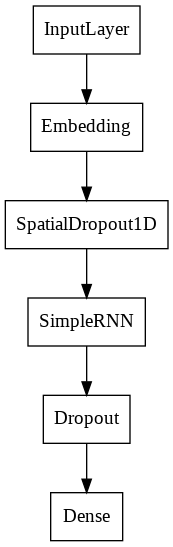

In [ ]:
plot_model(model_rnn_unres, to_file='/content/drive/My Drive/Tesis/Hasil NN Tesis/RNN/tesis_model_rnn_unres2.png', 
           show_shapes=False, show_layer_names=False)

In [ ]:
dropout_rate = 0.2
output_size = 16
maxlen = MAX_SEQUENCE_LENGTH
maxlen_vec = td
rnn_activation = 'tanh' #'relu' 

inputs = Input(shape=(maxlen_vec,))
#embedding_layer = Embedding(len(word_index) + 1,
                           # EMBEDDING_DIM,
                            #weights=[embedding_matrix],
                           # trainable=True)
#embedding = embedding_layer(inputs)

emb2 = Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], 
                 weights=[embedding_matrix], trainable=True)(inputs)

s_drop = SpatialDropout1D(dropout_rate)(emb2)
rnn = SimpleRNN(
    units=output_size, 
    activation=rnn_activation, 
    kernel_regularizer=regularizers.l2(0.1))(s_drop)
drop = Dropout(dropout_rate)(rnn)
output = Dense(units=num_classes, activation='softmax')(drop)

model_rnn_unres_vec = Model(inputs, output)
model_rnn_res_vec = Model(inputs, output)


model_rnn_unres_vec.compile(loss='categorical_crossentropy', metrics=['acc', f1_vec], optimizer=Adam(learning_rate=1e-3))
model_rnn_res_vec.compile(loss='categorical_crossentropy', metrics=['acc', f1_vec], optimizer=Adam(learning_rate=1e-3))

callbacks_unres_vec = [EarlyStopping(monitor='val_loss', verbose= 1, patience=20, mode='auto'), 
                       ModelCheckpoint('/content/drive/My Drive/Tesis/Hasil NN Tesis/RNN/tesis_model_rnn_unres_vec.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto'), 
                       ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_lr=0.001)]

callbacks_res_vec = [EarlyStopping(monitor='val_loss', verbose= 1, patience=20, mode='auto'), 
                     ModelCheckpoint('/content/drive/My Drive/Tesis/Hasil NN Tesis/RNN/tesis_model_rnn_res_vec.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto'), 
                     ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_lr=0.001)]

print('Model RNN UNRES VEC')
model_rnn_unres_vec.summary()
print('Model RNN RES VEC')
model_rnn_res_vec.summary()

Model RNN UNRES VEC
Model: "model_55"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_28 (InputLayer)        (None, 1000)              0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 1000, 300)         1905000   
_________________________________________________________________
spatial_dropout1d_7 (Spatial (None, 1000, 300)         0         
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 16)                5072      
_________________________________________________________________
dropout_7 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_72 (Dense)             (None, 3)                 51        
Total params: 1,910,123
Trainable params: 1,910,123
Non-trainable params: 0
____________________________

In [ ]:
tesis_model_rnn_unres_vec = model_rnn_unres_vec.fit(x2train_vec, y2train, batch_size=12, epochs=100, 
                                                    validation_data=(x2val_vec, y2val), callbacks=callbacks_unres_vec, shuffle=True, verbose=1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 4025 samples, validate on 1006 samples
Epoch 1/100
4025/4025 [==============================] - 102s 25ms/step - loss: 1.4740 - acc: 0.7180 - f1_vec: 0.7070 - val_loss: 0.8118 - val_acc: 0.7276 - val_f1_vec: 0.7276

Epoch 00001: val_loss improved from inf to 0.81179, saving model to /content/drive/My Drive/Tesis/Hasil NN Tesis/RNN/tesis_model_rnn_unres_vec.h5
Epoch 2/100
4025/4025 [==============================] - 103s 26ms/step - loss: 0.8105 - acc: 0.7262 - f1_vec: 0.7211 - val_loss: 0.7986 - val_acc: 0.7276 - val_f1_vec: 0.7276

Epoch 00002: val_loss improved from 0.81179 to 0.79863, saving model to /content/drive/My Drive/Tesis/Hasil NN Tesis/RNN/tesis_model_rnn_unres_vec.h5
Epoch 3/100
4025/4025 [==============================] - 102s 25ms/step - loss: 0.7913 - acc: 0.7277 - f1_vec: 0.7253 - val_loss: 0.7798 - val_acc: 0.7276 - val_f1_vec: 0.7276

Epoch 00003: val_loss improved from 0.79863 to 0.77979, saving model to /content/drive/My Drive/Tesis/Hasil NN Tesis/RNN/tesi

In [ ]:
tesis_model_rnn_res_vec = model_rnn_res_vec.fit(x2res, y2res, batch_size=12, epochs=100, 
                                                validation_data=(x2val_vec, y2val), callbacks=callbacks_res_vec, shuffle=True, verbose=1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 8786 samples, validate on 1006 samples
Epoch 1/100
8786/8786 [==============================] - 252s 29ms/step - loss: 1.1536 - acc: 0.3270 - f1_vec: 0.0303 - val_loss: 0.9806 - val_acc: 0.7276 - val_f1_vec: 0.0000e+00

Epoch 00001: val_loss improved from inf to 0.98055, saving model to /content/drive/My Drive/Tesis/Hasil NN Tesis/RNN/tesis_model_rnn_res_vec.h5
Epoch 2/100
8786/8786 [==============================] - 254s 29ms/step - loss: 1.1839 - acc: 0.3407 - f1_vec: 0.0013 - val_loss: 1.1379 - val_acc: 0.7276 - val_f1_vec: 0.0000e+00

Epoch 00002: val_loss did not improve from 0.98055
Epoch 3/100
8786/8786 [==============================] - 254s 29ms/step - loss: 1.1365 - acc: 0.3408 - f1_vec: 0.0000e+00 - val_loss: 1.0435 - val_acc: 0.7276 - val_f1_vec: 0.0000e+00

Epoch 00003: val_loss did not improve from 0.98055
Epoch 4/100
8786/8786 [==============================] - 263s 30ms/step - loss: 1.1222 - acc: 0.3326 - f1_vec: 2.0989e-04 - val_loss: 1.1382 - val_acc: 0.1809 

In [ ]:
simple_rnn_model = keras.models.load_model('tesis_simple_rnn.h5')
metrics = simple_rnn_model.evaluate(x_test, y_test)
print("{}: {}".format(simple_rnn_model.metrics_names[0], metrics[0]))
print("{}: {}".format(simple_rnn_model.metrics_names[1], metrics[1]))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


798/798 [==============================] - 0s 301us/step
loss: 1.062386693362903
acc: 0.6591478586196899


### **GRU**

In [ ]:
dropout_rate = 0.5
output_size = 16
maxlen = MAX_SEQUENCE_LENGTH
    
inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            trainable=True)
embedding = embedding_layer(inputs)

#emb2 = Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], 
#                 weights=[embedding_matrix], trainable=True)(inputs)

s_drop = SpatialDropout1D(dropout_rate)(embedding)
gru = GRU(units=output_size, return_sequences=True)(s_drop)
gru = GRU(units=output_size, return_sequences=False)(s_drop)
drop = Dropout(dropout_rate)(gru)
output = Dense(units=num_classes, activation='softmax')(drop)

model_gru_unres = Model(inputs, output)
model_gru_res = Model(inputs, output)

model_gru_unres.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['acc', f1])
model_gru_res.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['acc', f1])

callbacks_unres = [EarlyStopping(monitor='val_loss', verbose= 1, patience=10, mode='auto'), 
                   ModelCheckpoint('/content/drive/My Drive/Tesis/Hasil NN Tesis/GRU/tesis_model_gru_unres.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto'), 
                   ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.001)]

callbacks_res = [EarlyStopping(monitor='val_loss', verbose= 1, patience=10, mode='auto'), 
                 ModelCheckpoint('/content/drive/My Drive/Tesis/Hasil NN Tesis/GRU/tesis_model_gru_res.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto'), 
                 ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.001)]

print('Model GRU UNRES')
model_gru_unres.summary()
print('Model GRU RES')
model_gru_res.summary()

Model GRU UNRES
Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 50)                0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 50, 300)           1905000   
_________________________________________________________________
spatial_dropout1d_7 (Spatial (None, 50, 300)           0         
_________________________________________________________________
gru_2 (GRU)                  (None, 16)                15216     
_________________________________________________________________
dropout_6 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 3)                 51        
Total params: 1,920,267
Trainable params: 1,920,267
Non-trainable params: 0
________________________________

In [ ]:
tesis_model_gru_unres = model_gru_unres.fit(x_train, y_train, batch_size=12, epochs=100,
                                            validation_data=(x_val, y_val), callbacks=callbacks_unres, shuffle=True, verbose=1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 3756 samples, validate on 805 samples
Epoch 1/100
3756/3756 [==============================] - 57s 15ms/step - loss: 0.7090 - acc: 0.7460 - f1: 0.7222 - val_loss: 0.6062 - val_acc: 0.7677 - val_f1: 0.7697

Epoch 00001: val_loss improved from inf to 0.60624, saving model to /content/drive/My Drive/Tesis/Hasil NN Tesis/GRU/tesis_model_gru_unres.h5
Epoch 2/100
3756/3756 [==============================] - 56s 15ms/step - loss: 0.4997 - acc: 0.8198 - f1: 0.8150 - val_loss: 0.5614 - val_acc: 0.7888 - val_f1: 0.7772

Epoch 00002: val_loss improved from 0.60624 to 0.56144, saving model to /content/drive/My Drive/Tesis/Hasil NN Tesis/GRU/tesis_model_gru_unres.h5
Epoch 3/100
3756/3756 [==============================] - 56s 15ms/step - loss: 0.3700 - acc: 0.8717 - f1: 0.8654 - val_loss: 0.5662 - val_acc: 0.7950 - val_f1: 0.7844

Epoch 00003: val_loss did not improve from 0.56144
Epoch 4/100
3756/3756 [==============================] - 56s 15ms/step - loss: 0.2731 - acc: 0.9058 - f1: 0.90

In [ ]:
tesis_model_gru_res = model_gru_res.fit(x_res, y_res, batch_size=12, epochs=100, 
                                        validation_data=(x_val, y_val), callbacks=callbacks_res, shuffle=True, verbose=1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 8145 samples, validate on 805 samples
Epoch 1/100
8145/8145 [==============================] - 112s 14ms/step - loss: 0.9606 - acc: 0.5785 - f1: 0.5328 - val_loss: 0.9644 - val_acc: 0.6025 - val_f1: 0.5819

Epoch 00001: val_loss improved from inf to 0.96442, saving model to /content/drive/My Drive/Tesis/Hasil NN Tesis/GRU/tesis_model_gru_res.h5
Epoch 2/100
8145/8145 [==============================] - 111s 14ms/step - loss: 0.7248 - acc: 0.6819 - f1: 0.6465 - val_loss: 1.1201 - val_acc: 0.5801 - val_f1: 0.5471

Epoch 00002: val_loss did not improve from 0.96442
Epoch 3/100
8145/8145 [==============================] - 110s 14ms/step - loss: 0.6112 - acc: 0.7449 - f1: 0.7303 - val_loss: 1.2435 - val_acc: 0.5640 - val_f1: 0.5534

Epoch 00003: val_loss did not improve from 0.96442
Epoch 4/100
8145/8145 [==============================] - 111s 14ms/step - loss: 0.5388 - acc: 0.7849 - f1: 0.7730 - val_loss: 1.3620 - val_acc: 0.5677 - val_f1: 0.5518

Epoch 00004: val_loss did not impro

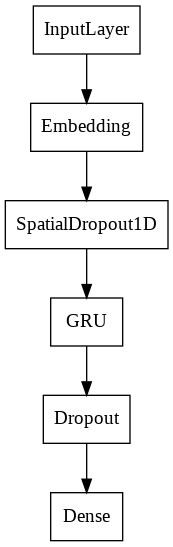

In [ ]:
plot_model(model_gru_unres, to_file='/content/drive/My Drive/Tesis/Hasil NN Tesis/GRU/tesis_model_gru_unres2.png', 
           show_shapes=False, show_layer_names=False)

In [ ]:
dropout_rate = 0.2
output_size = 16
maxlen = MAX_SEQUENCE_LENGTH
maxlen_vec = td
    
inputs = Input(shape=(maxlen_vec,))
#embedding_layer = Embedding(len(word_index) + 1,
                           # EMBEDDING_DIM,
                            #weights=[embedding_matrix],
                           # trainable=True)
#embedding = embedding_layer(inputs)

emb2 = Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], 
                 weights=[embedding_matrix], trainable=True)(inputs)

s_drop = SpatialDropout1D(dropout_rate)(emb2)
gru = GRU(units=output_size, return_sequences=False, kernel_regularizer=regularizers.l2(0.1))(s_drop)
drop = Dropout(dropout_rate)(gru)
output = Dense(units=num_classes, activation='softmax')(drop)

model_gru_unres_vec = Model(inputs, output)
model_gru_res_vec = Model(inputs, output)

model_gru_unres_vec.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-3), metrics=['acc', f1_vec])
model_gru_res_vec.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-3), metrics=['acc', f1_vec])

callbacks_unres_vec = [EarlyStopping(monitor='val_loss', verbose= 1, patience=10, mode='auto'), 
                       ModelCheckpoint('/content/drive/My Drive/Tesis/Hasil NN Tesis/GRU/tesis_model_gru_unres_vec.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto'),
                       ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.001)]

callbacks_res_vec = [EarlyStopping(monitor='val_loss', verbose= 1, patience=10, mode='auto'), 
                     ModelCheckpoint('/content/drive/My Drive/Tesis/Hasil NN Tesis/GRU/tesis_model_gru_res_vec.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto'),
                     ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.001)]

print('Model GRU UNRES VEC')
model_gru_unres_vec.summary()
print(' '*10)
print('Model GRU RES VEC')
model_gru_res_vec.summary()

Model GRU UNRES VEC
Model: "model_67"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_34 (InputLayer)        (None, 1000)              0         
_________________________________________________________________
embedding_13 (Embedding)     (None, 1000, 300)         1905000   
_________________________________________________________________
spatial_dropout1d_13 (Spatia (None, 1000, 300)         0         
_________________________________________________________________
gru_6 (GRU)                  (None, 16)                15216     
_________________________________________________________________
dropout_13 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_78 (Dense)             (None, 3)                 51        
Total params: 1,920,267
Trainable params: 1,920,267
Non-trainable params: 0
____________________________

In [ ]:
tesis_model_gru_unres_vec = model_gru_unres_vec.fit(x2train_vec, y2train, batch_size=12, epochs=100, 
                                                    validation_data=(x2val_vec, y2val), callbacks=callbacks_unres_vec, shuffle=True, verbose=1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 4025 samples, validate on 1006 samples
Epoch 1/100
4025/4025 [==============================] - 214s 53ms/step - loss: 2.0961 - acc: 0.7178 - f1_vec: 0.7055 - val_loss: 0.8579 - val_acc: 0.7276 - val_f1_vec: 0.7276

Epoch 00001: val_loss improved from inf to 0.85793, saving model to /content/drive/My Drive/Tesis/Hasil NN Tesis/GRU/tesis_model_gru_unres_vec.h5
Epoch 2/100
4025/4025 [==============================] - 215s 53ms/step - loss: 0.8179 - acc: 0.7272 - f1_vec: 0.7185 - val_loss: 0.8140 - val_acc: 0.7276 - val_f1_vec: 0.7276

Epoch 00002: val_loss improved from 0.85793 to 0.81398, saving model to /content/drive/My Drive/Tesis/Hasil NN Tesis/GRU/tesis_model_gru_unres_vec.h5
Epoch 3/100
4025/4025 [==============================] - 215s 54ms/step - loss: 0.7900 - acc: 0.7275 - f1_vec: 0.7258 - val_loss: 0.7782 - val_acc: 0.7276 - val_f1_vec: 0.7276

Epoch 00003: val_loss improved from 0.81398 to 0.77818, saving model to /content/drive/My Drive/Tesis/Hasil NN Tesis/GRU/tesi

In [ ]:
tesis_model_gru_res_vec = model_gru_res_vec.fit(x2res, y2res, batch_size=12, epochs=100, 
                                                validation_data=(x2val_vec, y2val), callbacks=callbacks_res_vec, shuffle=True, verbose=1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 8786 samples, validate on 1006 samples
Epoch 1/100
8786/8786 [==============================] - 496s 56ms/step - loss: 1.1397 - acc: 0.3383 - f1_vec: 0.0373 - val_loss: 1.1066 - val_acc: 0.0915 - val_f1_vec: 0.0000e+00

Epoch 00001: val_loss improved from inf to 1.10656, saving model to /content/drive/My Drive/Tesis/Hasil NN Tesis/GRU/tesis_model_gru_res_vec.h5
Epoch 2/100
8786/8786 [==============================] - 503s 57ms/step - loss: 1.1073 - acc: 0.3318 - f1_vec: 8.3954e-04 - val_loss: 1.0468 - val_acc: 0.7276 - val_f1_vec: 0.0000e+00

Epoch 00002: val_loss improved from 1.10656 to 1.04675, saving model to /content/drive/My Drive/Tesis/Hasil NN Tesis/GRU/tesis_model_gru_res_vec.h5
Epoch 3/100
8786/8786 [==============================] - 501s 57ms/step - loss: 1.1066 - acc: 0.3206 - f1_vec: 0.0000e+00 - val_loss: 1.0435 - val_acc: 0.7276 - val_f1_vec: 0.0000e+00

Epoch 00003: val_loss improved from 1.04675 to 1.04345, saving model to /content/drive/My Drive/Tesis/Hasil N

### **CNN**

#### CNN

In [ ]:
num_filters = 128
border_mode = 'same'
maxlen = MAX_SEQUENCE_LENGTH
#maxlen_vec = td
kernel_sizes = [5,5,5]
dropout_rate = 0.5

inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            trainable=True)
embedding = embedding_layer(inputs)

#emb2 = Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], 
#                 weights=[embedding_matrix], trainable=True)(inputs)

conv_0 = Conv1D(num_filters, kernel_sizes[0], activation = 'relu')(embedding) #padding=border_mode,
conv_0 = BatchNormalization()(conv_0)
maxpool_0 = MaxPooling1D(pool_size = (maxlen - kernel_sizes[0] + 1), strides=1, padding='valid')(conv_0)
    
conv_1 = Conv1D(num_filters, kernel_sizes[1], activation = 'relu')(embedding) #padding=border_mode,
conv_1 = BatchNormalization()(conv_1)
maxpool_1 = MaxPooling1D(pool_size = (maxlen - kernel_sizes[1] + 1), strides=1, padding='valid')(conv_1)
    
conv_2 = Conv1D(num_filters, kernel_sizes[2], activation = 'relu')(embedding) #padding=border_mode,
conv_2 = BatchNormalization()(conv_2)
maxpool_2 = MaxPooling1D(pool_size = (maxlen - kernel_sizes[2] + 1), strides=1, padding='valid')(conv_2)
    
merged = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2])
flatten = Flatten()(merged)
drop = Dropout(dropout_rate)(flatten)
output = Dense(units=num_classes, activation='softmax')(drop)

model_cnn_unres = Model(inputs, output)
model_cnn_res = Model(inputs, output)

model_cnn_unres.compile(loss='categorical_crossentropy', optimizer=rmsprop, metrics=['acc', f1])
model_cnn_res.compile(loss='categorical_crossentropy', optimizer=rmsprop, metrics=['acc', f1])

callbacks_unres = [EarlyStopping(monitor='val_loss', verbose= 1, patience=10, mode='auto'), 
                   ModelCheckpoint('/content/drive/My Drive/Tesis/Hasil NN Tesis/CNN/tesis_model_cnn_unres.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto'), 
                   ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.001)]

callbacks_res = [EarlyStopping(monitor='val_loss', verbose= 1, patience=10, mode='auto'), 
                 ModelCheckpoint('/content/drive/My Drive/Tesis/Hasil NN Tesis/CNN/tesis_model_cnn_res.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto'), 
                 ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.001)]

print('Model CNN UNRES')
model_cnn_unres.summary()
print('Model CNN RES')
model_cnn_res.summary()

Model CNN UNRES
Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 50, 300)      1905000     input_8[0][0]                    
__________________________________________________________________________________________________
conv1d_13 (Conv1D)              (None, 46, 128)      192128      embedding_8[0][0]                
__________________________________________________________________________________________________
conv1d_14 (Conv1D)              (None, 46, 128)      192128      embedding_8[0][0]                
___________________________________________________________________________

In [ ]:
tesis_model_cnn_unres = model_cnn_unres.fit(x_train, y_train, batch_size=12, epochs=100,
                                            validation_data=(x_val, y_val), callbacks=callbacks_unres, shuffle=True, verbose=1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 3756 samples, validate on 805 samples
Epoch 1/100
3756/3756 [==============================] - 6s 2ms/step - loss: 2.0938 - acc: 0.6374 - f1: 0.6339 - val_loss: 0.9706 - val_acc: 0.7292 - val_f1: 0.7328

Epoch 00001: val_loss improved from inf to 0.97059, saving model to /content/drive/My Drive/Tesis/Hasil NN Tesis/CNN/tesis_model_cnn_unres.h5
Epoch 2/100
3756/3756 [==============================] - 5s 1ms/step - loss: 0.8859 - acc: 0.7274 - f1: 0.7247 - val_loss: 0.7658 - val_acc: 0.7453 - val_f1: 0.7519

Epoch 00002: val_loss improved from 0.97059 to 0.76583, saving model to /content/drive/My Drive/Tesis/Hasil NN Tesis/CNN/tesis_model_cnn_unres.h5
Epoch 3/100
3756/3756 [==============================] - 5s 1ms/step - loss: 0.6677 - acc: 0.7833 - f1: 0.7822 - val_loss: 0.7127 - val_acc: 0.7627 - val_f1: 0.7612

Epoch 00003: val_loss improved from 0.76583 to 0.71267, saving model to /content/drive/My Drive/Tesis/Hasil NN Tesis/CNN/tesis_model_cnn_unres.h5
Epoch 4/100
3756/3756

In [ ]:
tesis_model_cnn_res = model_cnn_res.fit(x_res, y_res, batch_size=12, epochs=100, 
                                        validation_data=(x_val, y_val), callbacks=callbacks_res, shuffle=True, verbose=1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 8145 samples, validate on 805 samples
Epoch 1/100
8145/8145 [==============================] - 11s 1ms/step - loss: 1.8133 - acc: 0.4265 - f1: 0.3957 - val_loss: 1.1102 - val_acc: 0.4075 - val_f1: 0.3298

Epoch 00001: val_loss improved from inf to 1.11016, saving model to /content/drive/My Drive/Tesis/Hasil NN Tesis/CNN/tesis_model_cnn_res.h5
Epoch 2/100
8145/8145 [==============================] - 10s 1ms/step - loss: 1.0908 - acc: 0.4981 - f1: 0.4469 - val_loss: 0.8754 - val_acc: 0.6422 - val_f1: 0.5614

Epoch 00002: val_loss improved from 1.11016 to 0.87537, saving model to /content/drive/My Drive/Tesis/Hasil NN Tesis/CNN/tesis_model_cnn_res.h5
Epoch 3/100
8145/8145 [==============================] - 10s 1ms/step - loss: 0.9333 - acc: 0.5723 - f1: 0.5369 - val_loss: 1.2009 - val_acc: 0.4932 - val_f1: 0.4581

Epoch 00003: val_loss did not improve from 0.87537
Epoch 4/100
8145/8145 [==============================] - 10s 1ms/step - loss: 0.8442 - acc: 0.6303 - f1: 0.6075 - val

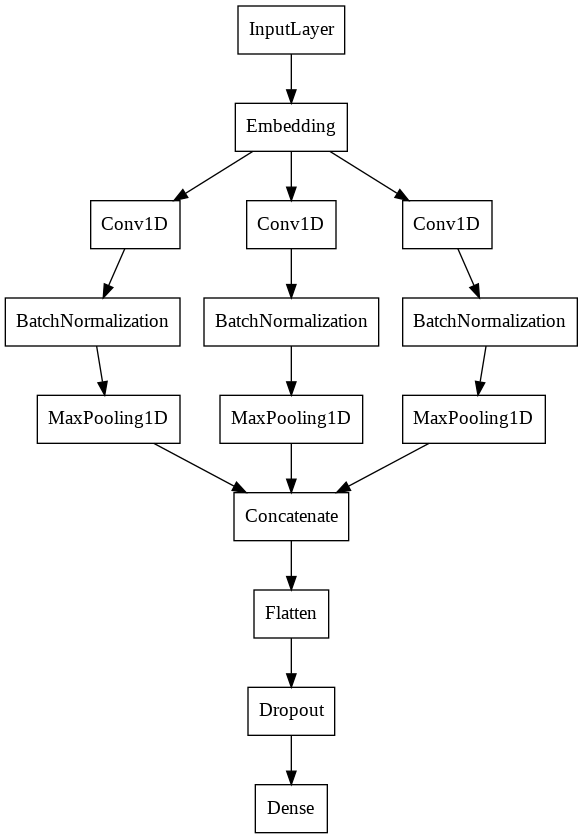

In [ ]:
plot_model(model_cnn_unres, to_file='/content/drive/My Drive/Tesis/Hasil NN Tesis/CNN/tesis_model_cnn_unres2.png', 
           show_shapes=False, show_layer_names=False)

In [ ]:
num_filters = 128
border_mode = 'same'
maxlen = MAX_SEQUENCE_LENGTH
maxlen_vec = td
kernel_sizes = [3,4,5]
dropout_rate = 0.5

inputs = Input(shape=(maxlen_vec,))
#embedding_layer = Embedding(len(word_index) + 1,
                           # EMBEDDING_DIM,
                            #weights=[embedding_matrix],
                           # trainable=True)
#embedding = embedding_layer(inputs)

emb2 = Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], 
                 weights=[embedding_matrix], 
                 trainable=True)(inputs)

conv_0 = Conv1D(num_filters, kernel_sizes[0], padding=border_mode, activation = 'relu', kernel_regularizer=regularizers.l2(0.1))(emb2)
conv_0 = BatchNormalization()(conv_0)
maxpool_0 = MaxPooling1D(pool_size = (maxlen_vec - kernel_sizes[0] + 1), strides=1, padding='valid')(conv_0)
    
conv_1 = Conv1D(num_filters, kernel_sizes[1], padding=border_mode, activation = 'relu', kernel_regularizer=regularizers.l2(0.1))(emb2)
conv_1 = BatchNormalization()(conv_1)
maxpool_1 = MaxPooling1D(pool_size = (maxlen_vec - kernel_sizes[1] + 1), strides=1, padding='valid')(conv_1)
    
conv_2 = Conv1D(num_filters, kernel_sizes[2], padding=border_mode, activation = 'relu', kernel_regularizer=regularizers.l2(0.1))(emb2)
conv_2 = BatchNormalization()(conv_2)
maxpool_2 = MaxPooling1D(pool_size = (maxlen_vec - kernel_sizes[2] + 1), strides=1, padding='valid')(conv_2)
    
merged = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2])
flatten = Flatten()(merged)
drop = Dropout(dropout_rate)(flatten)
output = Dense(units=num_classes, activation='softmax')(drop)

model_cnn_unres_vec = Model(inputs, output)
model_cnn_res_vec = Model(inputs, output)

model_cnn_unres_vec.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-3), metrics=['acc', f1_vec])
model_cnn_res_vec.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-3), metrics=['acc', f1_vec])

callbacks_unres_vec = [EarlyStopping(monitor='val_loss', verbose= 1, patience=10, mode='auto'), 
                   ModelCheckpoint('/content/drive/My Drive/Tesis/Hasil NN Tesis/CNN/tesis_model_cnn_unres_vec.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto'), 
                   ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.001)]

callbacks_res_vec = [EarlyStopping(monitor='val_loss', verbose= 1, patience=10, mode='auto'), 
                 ModelCheckpoint('/content/drive/My Drive/Tesis/Hasil NN Tesis/CNN/tesis_model_cnn_res_vec.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto'), 
                 ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.001)]

print('Model CNN UNRES VEC')
model_cnn_unres_vec.summary()
print('Model CNN RES VEC')
model_cnn_res_vec.summary()

Model CNN UNRES VEC
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 1000)         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1000, 300)    1905000     input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 1000, 128)    115328      embedding_2[0][0]                
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 1000, 128)    153728      embedding_2[0][0]                
________________________________________________________________________

In [ ]:
tesis_model_cnn_unres_vec = model_cnn_unres_vec.fit(x2train_vec, y2train, batch_size=12, epochs=100, 
                                                    validation_data=(x2val_vec, y2val), callbacks=callbacks_unres_vec, shuffle=True, verbose=1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 4025 samples, validate on 1006 samples
Epoch 1/50
4025/4025 [==============================] - 303s 75ms/step - loss: 2.9654 - acc: 0.7257 - f1_vec: 0.7203 - val_loss: 0.7870 - val_acc: 0.7276 - val_f1_vec: 0.7276

Epoch 00001: val_loss improved from inf to 0.78704, saving model to /content/drive/My Drive/Tesis/Hasil NN Tesis/CNN/tesis_model_cnn_unres_vec.h5
Epoch 2/50
4025/4025 [==============================] - 298s 74ms/step - loss: 0.7881 - acc: 0.7277 - f1_vec: 0.7275 - val_loss: 0.8121 - val_acc: 0.7276 - val_f1_vec: 0.7276

Epoch 00002: val_loss did not improve from 0.78704
Epoch 3/50
4025/4025 [==============================] - 295s 73ms/step - loss: 0.7792 - acc: 0.7277 - f1_vec: 0.7271 - val_loss: 0.7948 - val_acc: 0.7276 - val_f1_vec: 0.7276

Epoch 00003: val_loss did not improve from 0.78704
Epoch 4/50
4025/4025 [==============================] - 292s 73ms/step - loss: 0.7803 - acc: 0.7277 - f1_vec: 0.7278 - val_loss: 0.8748 - val_acc: 0.7276 - val_f1_vec: 0.7276



In [ ]:
tesis_model_cnn_res_vec = model_cnn_res_vec.fit(x2res, y2res, batch_size=12, epochs=100, 
                                                validation_data=(x2val_vec, y2val), callbacks=callbacks_res_vec, shuffle=True, verbose=1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 8786 samples, validate on 1006 samples
Epoch 1/100
8786/8786 [==============================] - 56s 6ms/step - loss: 5.8211 - acc: 0.3393 - f1_vec: 0.0905 - val_loss: 16.1502 - val_acc: 0.1809 - val_f1_vec: 0.1808

Epoch 00001: val_loss improved from inf to 16.15022, saving model to /content/drive/My Drive/Tesis/Hasil NN Tesis/CNN/tesis_model_cnn_res_vec.h5
Epoch 2/100
8786/8786 [==============================] - 49s 6ms/step - loss: 1.3756 - acc: 0.3405 - f1_vec: 0.0412 - val_loss: 12.9978 - val_acc: 0.1809 - val_f1_vec: 0.1808

Epoch 00002: val_loss improved from 16.15022 to 12.99776, saving model to /content/drive/My Drive/Tesis/Hasil NN Tesis/CNN/tesis_model_cnn_res_vec.h5
Epoch 3/100
8786/8786 [==============================] - 49s 6ms/step - loss: 1.2734 - acc: 0.3440 - f1_vec: 0.0365 - val_loss: 16.7113 - val_acc: 0.7276 - val_f1_vec: 0.7276

Epoch 00003: val_loss did not improve from 12.99776
Epoch 4/100
8786/8786 [==============================] - 48s 6ms/step - loss:

##### CNN TEST

In [ ]:
filter_sizes = [5,5,5]
num_filters = 128
drop = 0.5
MAX_SEQUENCE_LENGTH = 50
maxlen = MAX_SEQUENCE_LENGTH

inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)
embedding = embedding_layer(inputs)

conv_0 = Conv1D(num_filters, filter_sizes[0],activation='relu')(embedding)
conv_1 = Conv1D(num_filters, filter_sizes[1],activation='relu')(embedding)
conv_2 = Conv1D(num_filters, filter_sizes[2],activation='relu')(embedding)

maxpool_0 = MaxPooling1D(maxlen - filter_sizes[0] + 1, strides=1)(conv_0)
maxpool_1 = MaxPooling1D(maxlen - filter_sizes[1] + 1, strides=1)(conv_1)
maxpool_2 = MaxPooling1D(maxlen - filter_sizes[2] + 1, strides=1)(conv_2)

merged_tensor = concatenate([maxpool_0, maxpool_1, maxpool_2], axis=1)
flatten = Flatten()(merged_tensor)

dense1 = Dense(256)(flatten)
dropout = Dropout(drop)(dense1)
output = Dense(units=num_classes, activation='softmax')(dropout)

model2 = Model(inputs, output)

model2.compile(loss='categorical_crossentropy', metrics=['acc'], optimizer=adam)
callbacks = [EarlyStopping(patience=6),ModelCheckpoint('tesis_cnn_unres.h5', monitor='val_acc', verbose=1, save_best_only=True)]

model2.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 50, 300)      1905000     input_3[0][0]                    
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 46, 128)      192128      embedding_3[0][0]                
__________________________________________________________________________________________________
conv1d_8 (Conv1D)               (None, 46, 128)      192128      embedding_3[0][0]                
____________________________________________________________________________________________

In [ ]:
model2 = model2.fit(x_res, y_res, batch_size=12, epochs=50, validation_data=(x_val, y_val), callbacks=callbacks_unres, shuffle=True, verbose=1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 8145 samples, validate on 805 samples
Epoch 1/50
8145/8145 [==============================] - 9s 1ms/step - loss: 2.2041 - acc: 0.3428 - val_loss: 4.5086 - val_acc: 0.1118

Epoch 00001: val_loss improved from inf to 4.50865, saving model to /content/drive/My Drive/Tesis/Hasil NN Tesis/CNN/tesis_model_cnn_unres.h5
Epoch 2/50
4524/8145 [===============>..............] - ETA: 3s - loss: 19.4463 - acc: 0.3324

KeyboardInterrupt: ignored

In [ ]:
model_cnn_unres = model.fit(x_train, y_train, validation_data=(x_val, y_val),epochs=50, batch_size=12, callbacks=callbacks)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 3722 samples, validate on 798 samples
Epoch 1/50
3722/3722 [==============================] - 39s 10ms/step - loss: 0.8455 - acc: 0.6886 - val_loss: 0.7553 - val_acc: 0.7256

Epoch 00001: val_acc improved from -inf to 0.72556, saving model to tesis_cnn_unres.h5
Epoch 2/50
3722/3722 [==============================] - 38s 10ms/step - loss: 0.7493 - acc: 0.7136 - val_loss: 0.7099 - val_acc: 0.7243

Epoch 00002: val_acc did not improve from 0.72556
Epoch 3/50
3722/3722 [==============================] - 38s 10ms/step - loss: 0.6890 - acc: 0.7351 - val_loss: 0.7133 - val_acc: 0.7356

Epoch 00003: val_acc improved from 0.72556 to 0.73559, saving model to tesis_cnn_unres.h5
Epoch 4/50
3722/3722 [==============================] - 38s 10ms/step - loss: 0.6260 - acc: 0.7638 - val_loss: 0.6694 - val_acc: 0.7431

Epoch 00004: val_acc improved from 0.73559 to 0.74311, saving model to tesis_cnn_unres.h5
Epoch 5/50
3722/3722 [==============================] - 40s 11ms/step - loss: 0.5542 - a

In [ ]:
cnn_model_unres = keras.models.load_model('tesis_cnn_unres.h5')
metrics = cnn_model_unres.evaluate(x_test, y_test)
print("{}: {}".format(model.metrics_names[0], metrics[0]))
print("{}: {}".format(model.metrics_names[1], metrics[1]))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


798/798 [==============================] - 1s 1ms/step
loss: 0.6671034775879747
acc: 0.7781955003738403


##### CNN/SMOTETOMEK

In [ ]:
filter_sizes = [5,5,5]
num_filters = 128
drop = 0.5
MAX_SEQUENCE_LENGTH = 50
maxlen = MAX_SEQUENCE_LENGTH

inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)
embedding = embedding_layer(inputs)

conv_0 = Conv1D(num_filters, filter_sizes[0], activation='relu')(embedding)
conv_1 = Conv1D(num_filters, filter_sizes[1], activation='relu')(embedding)
conv_2 = Conv1D(num_filters, filter_sizes[2], activation='relu')(embedding)

maxpool_0 = MaxPooling1D(maxlen - filter_sizes[0] + 1, strides=1)(conv_0)
maxpool_1 = MaxPooling1D(maxlen - filter_sizes[1] + 1, strides=1)(conv_1)
maxpool_2 = MaxPooling1D(maxlen - filter_sizes[2] + 1, strides=1)(conv_2)

merged_tensor = concatenate([maxpool_0, maxpool_1, maxpool_2], axis=1)
flatten = Flatten()(merged_tensor)

dense1 = Dense(256)(flatten)
dropout = Dropout(drop)(dense1)
output = Dense(units=num_classes, activation='softmax')(dropout)

model = Model(inputs, output)

model.compile(loss='categorical_crossentropy', metrics=['acc'], optimizer=adam2)
callbacks = [EarlyStopping(patience=6),ModelCheckpoint('tesis_cnn_res_smotetomek.h5', monitor='val_acc', verbose=1, save_best_only=True)]

model.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_22 (Embedding)        (None, 50, 300)      1904400     input_12[0][0]                   
__________________________________________________________________________________________________
conv1d_25 (Conv1D)              (None, 46, 128)      192128      embedding_22[0][0]               
__________________________________________________________________________________________________
conv1d_26 (Conv1D)              (None, 46, 128)      192128      embedding_22[0][0]               
___________________________________________________________________________________________

In [ ]:
model_cnn_res_smotetomek = model.fit(x_res, y_res, validation_data=(x_val, y_val),epochs=50, batch_size=12, callbacks=callbacks)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 7976 samples, validate on 798 samples
Epoch 1/50
7976/7976 [==============================] - 83s 10ms/step - loss: 1.0818 - acc: 0.4511 - val_loss: 0.9075 - val_acc: 0.5890

Epoch 00001: val_acc improved from -inf to 0.58897, saving model to tesis_cnn_res_smotetomek.h5
Epoch 2/50
7976/7976 [==============================] - 90s 11ms/step - loss: 0.9337 - acc: 0.5350 - val_loss: 0.8561 - val_acc: 0.6504

Epoch 00002: val_acc improved from 0.58897 to 0.65038, saving model to tesis_cnn_res_smotetomek.h5
Epoch 3/50
7976/7976 [==============================] - 91s 11ms/step - loss: 0.8246 - acc: 0.6236 - val_loss: 0.8657 - val_acc: 0.6328

Epoch 00003: val_acc did not improve from 0.65038
Epoch 4/50
7976/7976 [==============================] - 91s 11ms/step - loss: 0.7030 - acc: 0.7022 - val_loss: 0.8577 - val_acc: 0.6491

Epoch 00004: val_acc did not improve from 0.65038
Epoch 5/50
7976/7976 [==============================] - 90s 11ms/step - loss: 0.5654 - acc: 0.7861 - val_loss:

In [ ]:
cnn_model_res_smotetomek = keras.models.load_model('tesis_cnn_res_smotetomek.h5')
metrics = cnn_model_res_smotetomek.evaluate(x_test, y_test)
print("{}: {}".format(model.metrics_names[0], metrics[0]))
print("{}: {}".format(model.metrics_names[1], metrics[1]))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


798/798 [==============================] - 1s 1ms/step
loss: 0.790859742122784
acc: 0.7167919874191284


In [ ]:
def get_output_cnn(model, x_train, x_test):
    total_layers = len(model.layers)
    fl_index = total_layers-1
    feature_layer_model = Model(
                     inputs=model.input,
                     outputs=model.get_layer(index=fl_index).output)
    x_train_xg = feature_layer_model.predict(x_train)
    x_test_xg = feature_layer_model.predict(x_test)
    return x_train_xg, x_test_xg

In [ ]:
x_train_xg, x_test_xg = get_output_cnn(cnn_model, x_res, x_test)

In [ ]:
pip install scikit-multilearn

     |████████████████████████████████| 92kB 2.7MB/s 


In [ ]:
from skmultilearn.problem_transform import ClassifierChain
from xgboost import XGBClassifier

clf = ClassifierChain(XGBClassifier())
clf.fit(x_train_xg, y_res)
y_pred = clf.predict(x_test_xg)

f1 = f1_score(y_test, y_pred, average='macro')
print(f1)

0.5024551268929588


In [ ]:
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.8644    0.6166    0.7198       579
           1     0.4000    0.6301    0.4894       146
           2     0.2194    0.4658    0.2982        73

   micro avg     0.6053    0.6053    0.6053       798
   macro avg     0.4946    0.5708    0.5025       798
weighted avg     0.7204    0.6053    0.6390       798
 samples avg     0.6053    0.6053    0.6053       798



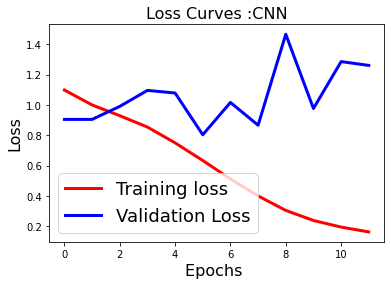

In [ ]:
plt.switch_backend('agg')
%matplotlib inline

fig1 = plt.figure()
plt.plot(model_cnn.history['loss'],'r',linewidth=3.0)
plt.plot(model_cnn.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves :CNN',fontsize=16)
fig1.savefig('loss_cnn.png')
plt.show()

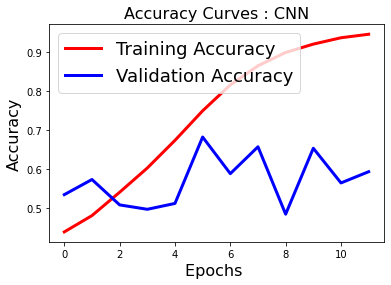

In [ ]:
fig2=plt.figure()
plt.plot(model_cnn.history['acc'],'r',linewidth=3.0)
plt.plot(model_cnn.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves : CNN',fontsize=16)
fig2.savefig('accuracy_cnn.png')
plt.show()

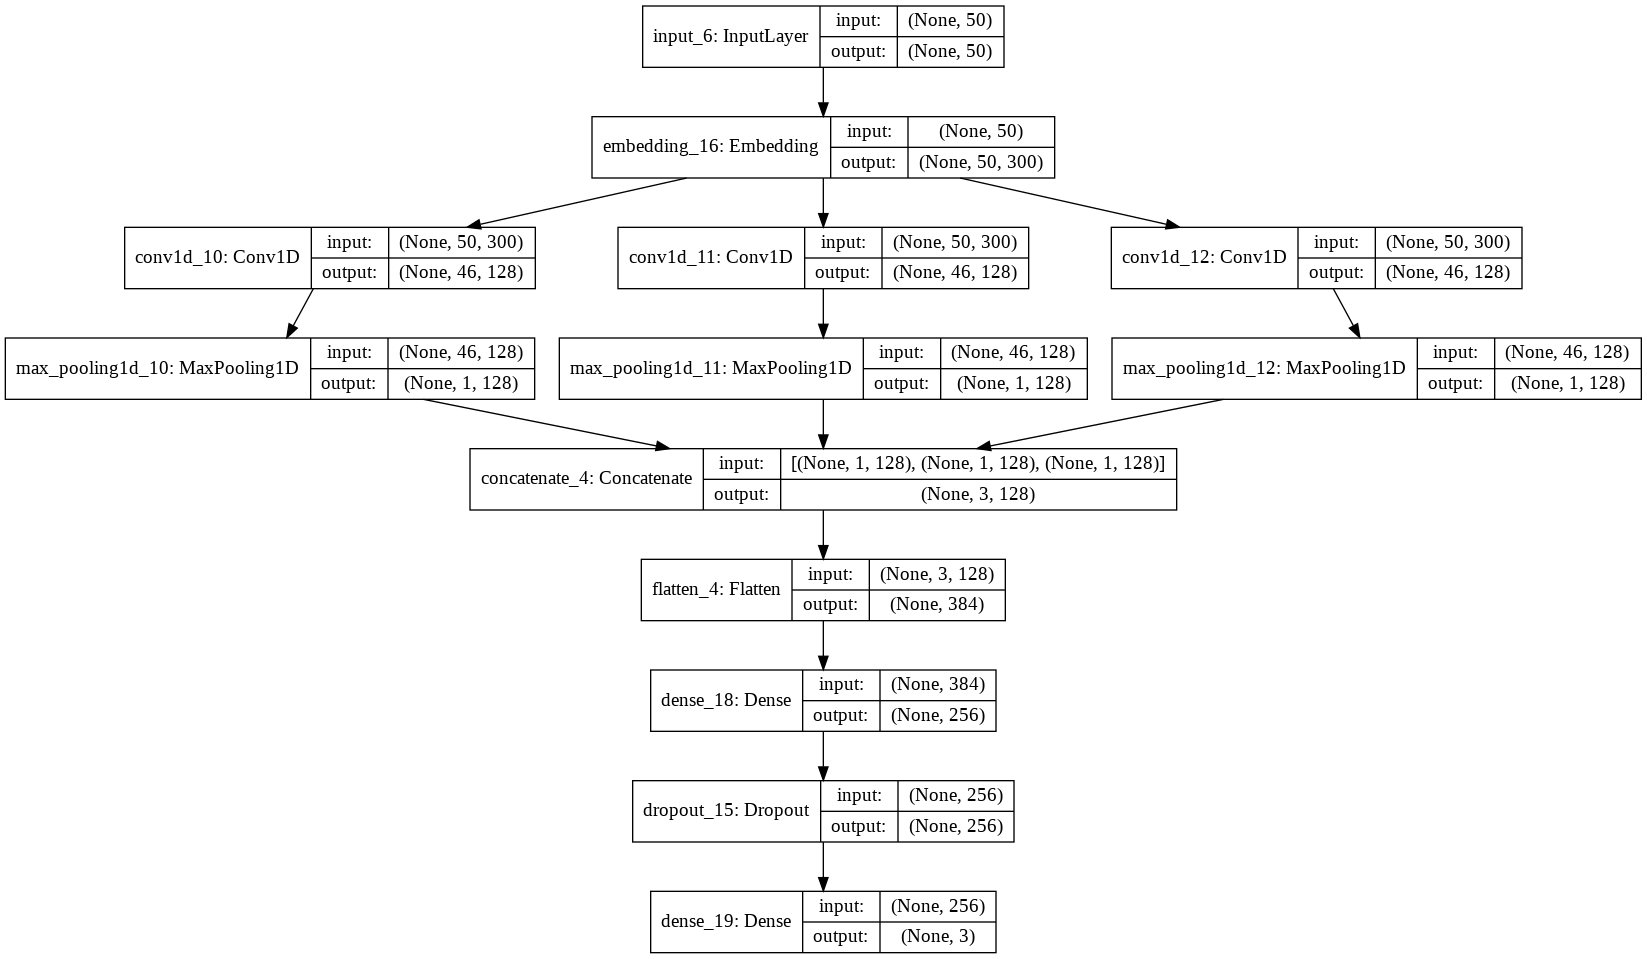

In [ ]:
plot_model(model, to_file='cnn_model.png', show_shapes=True, show_layer_names=True)

##### CNN/TFIDF

In [ ]:
x2res.shape, y2res.shape

((8672, 1000), (8672, 3))

In [ ]:
filter_sizes = [5,5,5]
num_filters = 128
drop = 0.5
MAX_SEQUENCE_LENGTH = 1000
maxlen = MAX_SEQUENCE_LENGTH

inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)
embedding = embedding_layer(inputs)

conv_0 = Conv1D(num_filters, filter_sizes[0],activation='relu')(embedding)
conv_1 = Conv1D(num_filters, filter_sizes[1],activation='relu')(embedding)
conv_2 = Conv1D(num_filters, filter_sizes[2],activation='relu')(embedding)

maxpool_0 = MaxPooling1D(maxlen - filter_sizes[0] + 1, strides=1)(conv_0)
maxpool_1 = MaxPooling1D(maxlen - filter_sizes[1] + 1, strides=1)(conv_1)
maxpool_2 = MaxPooling1D(maxlen - filter_sizes[2] + 1, strides=1)(conv_2)

merged_tensor = concatenate([maxpool_0, maxpool_1, maxpool_2], axis=1)
flatten = Flatten()(merged_tensor)

dense1 = Dense(256)(flatten)
dropout = Dropout(drop)(dense1)
output = Dense(units=num_classes, activation='softmax')(dropout)

model = Model(inputs, output)

model.compile(loss='categorical_crossentropy', metrics=['acc'], optimizer=adam2)
callbacks = [EarlyStopping(patience=6),ModelCheckpoint('tesis_cnn_vec_unres.h5', monitor='val_acc', verbose=1, save_best_only=True)]

model.summary()

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           (None, 1000)         0                                            
__________________________________________________________________________________________________
embedding_24 (Embedding)        (None, 1000, 300)    1904400     input_14[0][0]                   
__________________________________________________________________________________________________
conv1d_31 (Conv1D)              (None, 996, 128)     192128      embedding_24[0][0]               
__________________________________________________________________________________________________
conv1d_32 (Conv1D)              (None, 996, 128)     192128      embedding_24[0][0]               
___________________________________________________________________________________________

In [ ]:
model_cnn_vec_unres = model.fit(x2train_vec, y2train, validation_data=(x2val_vec, y2val),epochs=50, batch_size=12, callbacks=callbacks)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 3988 samples, validate on 997 samples
Epoch 1/50
3988/3988 [==============================] - 339s 85ms/step - loss: 0.8089 - acc: 0.7116 - val_loss: 0.7680 - val_acc: 0.7252

Epoch 00001: val_acc improved from -inf to 0.72518, saving model to tesis_cnn_vec_unres.h5
Epoch 2/50
3988/3988 [==============================] - 336s 84ms/step - loss: 0.7773 - acc: 0.7252 - val_loss: 0.7650 - val_acc: 0.7252

Epoch 00002: val_acc did not improve from 0.72518
Epoch 3/50
3988/3988 [==============================] - 336s 84ms/step - loss: 0.7711 - acc: 0.7252 - val_loss: 0.7650 - val_acc: 0.7252

Epoch 00003: val_acc did not improve from 0.72518
Epoch 4/50
3988/3988 [==============================] - 335s 84ms/step - loss: 0.7748 - acc: 0.7252 - val_loss: 0.7637 - val_acc: 0.7252

Epoch 00004: val_acc did not improve from 0.72518
Epoch 5/50
3988/3988 [==============================] - 341s 86ms/step - loss: 0.7716 - acc: 0.7252 - val_loss: 0.7652 - val_acc: 0.7252

Epoch 00005: val_acc d

In [ ]:
cnn_model_vec_unres = keras.models.load_model('tesis_cnn_vec_unres.h5')
metrics = cnn_model_vec_unres.evaluate(x2test_vec, y2test)
print("{}: {}".format(model.metrics_names[0], metrics[0]))
print("{}: {}".format(model.metrics_names[1], metrics[1]))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


333/333 [==============================] - 7s 21ms/step
loss: 0.7607598515960189
acc: 0.7267267107963562


##### CNN/TFIDF/SMOTETOMEK

In [ ]:
filter_sizes = [5,5,5]
num_filters = 128
drop = 0.5
MAX_SEQUENCE_LENGTH = 1000
maxlen = MAX_SEQUENCE_LENGTH

inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)
embedding = embedding_layer(inputs)

conv_0 = Conv1D(num_filters, filter_sizes[0],activation='relu')(embedding)
conv_1 = Conv1D(num_filters, filter_sizes[1],activation='relu')(embedding)
conv_2 = Conv1D(num_filters, filter_sizes[2],activation='relu')(embedding)

maxpool_0 = MaxPooling1D(maxlen - filter_sizes[0] + 1, strides=1)(conv_0)
maxpool_1 = MaxPooling1D(maxlen - filter_sizes[1] + 1, strides=1)(conv_1)
maxpool_2 = MaxPooling1D(maxlen - filter_sizes[2] + 1, strides=1)(conv_2)

merged_tensor = concatenate([maxpool_0, maxpool_1, maxpool_2], axis=1)
flatten = Flatten()(merged_tensor)

dense1 = Dense(256)(flatten)
dropout = Dropout(drop)(dense1)
output = Dense(units=num_classes, activation='softmax')(dropout)

model = Model(inputs, output)

model.compile(loss='categorical_crossentropy', metrics=['acc'], optimizer=adam2)
callbacks = [EarlyStopping(patience=6),ModelCheckpoint('tesis_cnn_vec_res_smotetomek.h5', monitor='val_acc', verbose=1, save_best_only=True)]

model.summary()

Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, 1000)         0                                            
__________________________________________________________________________________________________
embedding_25 (Embedding)        (None, 1000, 300)    1904400     input_15[0][0]                   
__________________________________________________________________________________________________
conv1d_34 (Conv1D)              (None, 996, 128)     192128      embedding_25[0][0]               
__________________________________________________________________________________________________
conv1d_35 (Conv1D)              (None, 996, 128)     192128      embedding_25[0][0]               
___________________________________________________________________________________________

In [ ]:
model_cnn_vec_res_smotetomek = model.fit(x2res, y2res, validation_data=(x2val_vec, y2val),epochs=50, batch_size=12, callbacks=callbacks)

Train on 8672 samples, validate on 997 samples
Epoch 1/50
8672/8672 [==============================] - 704s 81ms/step - loss: 1.0966 - acc: 0.3547 - val_loss: 1.0691 - val_acc: 0.1605

Epoch 00001: val_acc improved from -inf to 0.16048, saving model to tesis_cnn_vec_res_smotetomek.h5
Epoch 2/50
8672/8672 [==============================] - 708s 82ms/step - loss: 1.0811 - acc: 0.3615 - val_loss: 1.0886 - val_acc: 0.1605

Epoch 00002: val_acc did not improve from 0.16048
Epoch 3/50
8672/8672 [==============================] - 689s 79ms/step - loss: 1.0806 - acc: 0.3635 - val_loss: 1.0950 - val_acc: 0.1605

Epoch 00003: val_acc did not improve from 0.16048
Epoch 4/50
8672/8672 [==============================] - 692s 80ms/step - loss: 1.0804 - acc: 0.3658 - val_loss: 1.1000 - val_acc: 0.1605

Epoch 00004: val_acc did not improve from 0.16048
Epoch 5/50
8672/8672 [==============================] - 701s 81ms/step - loss: 1.0805 - acc: 0.3654 - val_loss: 1.0932 - val_acc: 0.1605

Epoch 00005: 

In [ ]:
cnn_model_vec_res_smotetomek = keras.models.load_model('tesis_cnn_vec_res_smotetomek.h5')
metrics = cnn_model_vec_res_smotetomek.evaluate(x2test_vec, y2test)
print("{}: {}".format(model.metrics_names[0], metrics[0]))
print("{}: {}".format(model.metrics_names[1], metrics[1]))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


333/333 [==============================] - 7s 20ms/step
loss: 1.065928261201303
acc: 0.15615615248680115


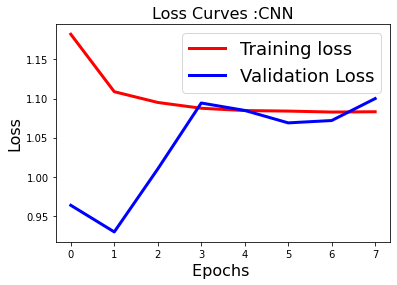

In [ ]:
plt.switch_backend('agg')
%matplotlib inline

fig1 = plt.figure()
plt.plot(historyvec.history['loss'],'r',linewidth=3.0)
plt.plot(historyvec.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves :CNN',fontsize=16)
fig1.savefig('loss_cnn.png')
plt.show()

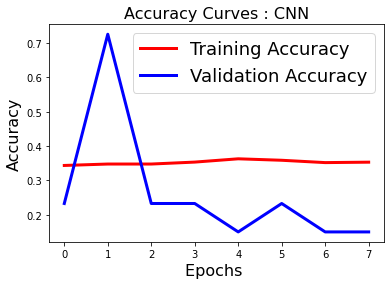

In [ ]:
fig2=plt.figure()
plt.plot(historyvec.history['acc'],'r',linewidth=3.0)
plt.plot(historyvec.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves : CNN',fontsize=16)
fig2.savefig('accuracy_cnn.png')
plt.show()

### **LSTM**

##### LSTM

In [ ]:
maxlen = MAX_SEQUENCE_LENGTH
#maxlen_vec = td
lstm_cell = 128
dropout_rate = 0.5

inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            trainable=True)
embedding = embedding_layer(inputs)

#emb2 = Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], 
#                 weights=[embedding_matrix], trainable=True)(inputs)

s_drop = SpatialDropout1D(dropout_rate)(embedding)
lstm = LSTM((lstm_cell), return_sequences=True)(s_drop)
lstm = LSTM((lstm_cell), return_sequences=False)(s_drop)
drop = Dropout(dropout_rate)(lstm)
output = Dense(units=num_classes, activation='softmax')(drop)

model_lstm_unres = Model(inputs, output)
model_lstm_res = Model(inputs, output)

model_lstm_unres.compile(loss='categorical_crossentropy', optimizer=rmsprop, metrics=['acc', f1, TP, TN])
model_lstm_res.compile(loss='categorical_crossentropy', optimizer=rmsprop, metrics=['acc', f1, TP, TN])

callbacks_unres = [EarlyStopping(monitor='val_loss', verbose= 1, patience=10, mode='auto'), 
                   ModelCheckpoint('/content/drive/My Drive/Tesis/Hasil NN Tesis/LSTM/tesis_model_lstm_unres2.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto'), 
                   ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.001)]

callbacks_res = [EarlyStopping(monitor='val_loss', verbose= 1, patience=10, mode='auto'), 
                 ModelCheckpoint('/content/drive/My Drive/Tesis/Hasil NN Tesis/LSTM/tesis_model_lstm_res2.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto'), 
                 ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.001)]

print('Model LSTM UNRES')
model_lstm_unres.summary()
print('Model LSTM RES')
model_lstm_res.summary()

Model LSTM UNRES
Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 50)                0         
_________________________________________________________________
embedding_9 (Embedding)      (None, 50, 300)           1905000   
_________________________________________________________________
spatial_dropout1d_8 (Spatial (None, 50, 300)           0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 128)               219648    
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 3)                 387       
Total params: 2,125,035
Trainable params: 2,125,035
Non-trainable params: 0
_______________________________

In [ ]:
tesis_model_lstm_unres = model_lstm_unres.fit(x_train, y_train, batch_size=12, epochs=100,
                                            validation_data=(x_val, y_val), callbacks=callbacks_unres, shuffle=True, verbose=1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 3756 samples, validate on 805 samples
Epoch 1/100
3756/3756 [==============================] - 47s 12ms/step - loss: 0.6882 - acc: 0.7463 - f1: 0.7368 - val_loss: 0.6056 - val_acc: 0.7752 - val_f1: 0.7591

Epoch 00001: val_loss improved from inf to 0.60560, saving model to /content/drive/My Drive/Tesis/Hasil NN Tesis/LSTM/tesis_model_lstm_unres.h5
Epoch 2/100
3756/3756 [==============================] - 46s 12ms/step - loss: 0.4634 - acc: 0.8320 - f1: 0.8241 - val_loss: 0.5684 - val_acc: 0.7901 - val_f1: 0.7745

Epoch 00002: val_loss improved from 0.60560 to 0.56845, saving model to /content/drive/My Drive/Tesis/Hasil NN Tesis/LSTM/tesis_model_lstm_unres.h5
Epoch 3/100
3756/3756 [==============================] - 47s 12ms/step - loss: 0.3058 - acc: 0.8932 - f1: 0.8915 - val_loss: 0.5864 - val_acc: 0.7801 - val_f1: 0.7677

Epoch 00003: val_loss did not improve from 0.56845
Epoch 4/100
3756/3756 [==============================] - 46s 12ms/step - loss: 0.2211 - acc: 0.9183 - f1: 

In [ ]:
tesis_model_lstm_res = model_lstm_res.fit(x_res, y_res, batch_size=12, epochs=100, 
                                        validation_data=(x_val, y_val), callbacks=callbacks_res, shuffle=True, verbose=1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 8145 samples, validate on 805 samples
Epoch 1/100
8145/8145 [==============================] - 86s 11ms/step - loss: 0.8559 - acc: 0.6041 - f1: 0.5675 - val_loss: 0.8053 - val_acc: 0.6882 - val_f1: 0.6663

Epoch 00001: val_loss improved from inf to 0.80527, saving model to /content/drive/My Drive/Tesis/Hasil NN Tesis/LSTM/tesis_model_lstm_res.h5
Epoch 2/100
8145/8145 [==============================] - 85s 10ms/step - loss: 0.6054 - acc: 0.7254 - f1: 0.7169 - val_loss: 1.3855 - val_acc: 0.5789 - val_f1: 0.5682

Epoch 00002: val_loss did not improve from 0.80527
Epoch 3/100
8145/8145 [==============================] - 84s 10ms/step - loss: 0.4822 - acc: 0.7929 - f1: 0.7855 - val_loss: 1.3981 - val_acc: 0.5789 - val_f1: 0.5684

Epoch 00003: val_loss did not improve from 0.80527
Epoch 4/100
8145/8145 [==============================] - 85s 10ms/step - loss: 0.3894 - acc: 0.8381 - f1: 0.8362 - val_loss: 1.6045 - val_acc: 0.6099 - val_f1: 0.5915

Epoch 00004: val_loss did not improve

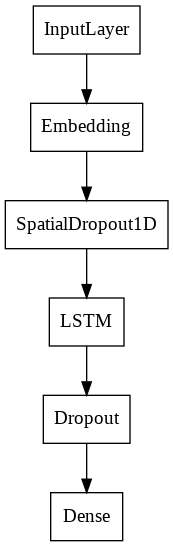

In [ ]:
plot_model(model_lstm_unres, to_file='/content/drive/My Drive/Tesis/Hasil NN Tesis/LSTM/tesis_model_lstm_unres2.png', 
           show_shapes=False, show_layer_names=False)

##### BiLSTM

In [ ]:
maxlen = MAX_SEQUENCE_LENGTH
#maxlen_vec = td
lstm_cell = 128
dropout_rate = 0.5

inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            trainable=True)
embedding = embedding_layer(inputs)

#emb2 = Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], 
#                 weights=[embedding_matrix], trainable=True)(inputs)

s_drop = SpatialDropout1D(dropout_rate)(embedding)
lstm = Bidirectional(LSTM((lstm_cell), return_sequences=True))(s_drop)
lstm = Bidirectional(LSTM((lstm_cell), return_sequences=False))(s_drop)
drop = Dropout(dropout_rate)(lstm)
output = Dense(units=num_classes, activation='softmax')(drop)

model_bilstm_unres = Model(inputs, output)
model_bilstm_res = Model(inputs, output)

model_bilstm_unres.compile(loss='categorical_crossentropy', optimizer=rmsprop, metrics=['acc', f1])
model_bilstm_res.compile(loss='categorical_crossentropy', optimizer=rmsprop, metrics=['acc', f1])

callbacks_unres = [EarlyStopping(monitor='val_loss', verbose= 1, patience=10, mode='auto'), 
                   ModelCheckpoint('/content/drive/My Drive/Tesis/Hasil NN Tesis/LSTM/tesis_model_bilstm_unres.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto'), 
                   ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.001)]

callbacks_res = [EarlyStopping(monitor='val_loss', verbose= 1, patience=10, mode='auto'), 
                 ModelCheckpoint('/content/drive/My Drive/Tesis/Hasil NN Tesis/LSTM/tesis_model_bilstm_res.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto'), 
                 ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.001)]

print('Model BiLSTM UNRES')
model_bilstm_unres.summary()
print('Model BiLSTM RES')
model_bilstm_res.summary()

Model BiLSTM UNRES
Model: "model_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 50)                0         
_________________________________________________________________
embedding_17 (Embedding)     (None, 50, 300)           1905000   
_________________________________________________________________
spatial_dropout1d_11 (Spatia (None, 50, 300)           0         
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 256)               439296    
_________________________________________________________________
dropout_14 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 3)                 771       
Total params: 2,345,067
Trainable params: 2,345,067
Non-trainable params: 0
_____________________________

In [ ]:
maxlen = MAX_SEQUENCE_LENGTH
maxlen_vec = td
lstm_cell = 128
dropout_rate = 0.5

inputs = Input(shape=(maxlen_vec,))
#embedding_layer = Embedding(len(word_index) + 1,
                           # EMBEDDING_DIM,
                            #weights=[embedding_matrix],
                           # trainable=True)
#embedding = embedding_layer(inputs)

emb2 = Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], 
                 weights=[embedding_matrix], trainable=True)(inputs)

s_drop = SpatialDropout1D(dropout_rate)(emb2)
lstm = LSTM((lstm_cell), return_sequences=False)(s_drop)
drop = Dropout(dropout_rate)(lstm)
output = Dense(units=num_classes, activation='softmax')(drop)

model_lstm_unres_vec = Model(inputs, output)
model_lstm_res_vec = Model(inputs, output)

model_lstm_unres_vec.compile(loss='categorical_crossentropy', optimizer=rmsprop, metrics=['acc', f1])
model_lstm_res_vec.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['acc', f1])

callbacks_unres_vec = [EarlyStopping(monitor='val_loss', verbose= 1, patience=10, mode='auto'), 
                   ModelCheckpoint('/content/drive/My Drive/Tesis/Hasil NN Tesis/LSTM/tesis_model_lstm_unres_vec.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto'), 
                   ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.001)]

callbacks_res_vec = [EarlyStopping(monitor='val_loss', verbose= 1, patience=10, mode='auto'), 
                 ModelCheckpoint('/content/drive/My Drive/Tesis/Hasil NN Tesis/LSTM/tesis_model_lstm_res_vec.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto'), 
                 ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.001)]

print('Model LSTM UNRES VEC')
model_lstm_unres_vec.summary()
print('Model LSTM RES VEC')
model_lstm_res_vec.summary()

Model LSTM UNRES VEC
Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 1000, 300)         1905000   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 1000, 300)         0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               219648    
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 387       
Total params: 2,125,035
Trainable params: 2,125,035
Non-trainable params: 0
____________________________

In [ ]:
tesis_model_bilstm_unres = model_bilstm_unres.fit(x_train, y_train, batch_size=12, epochs=100,
                                            validation_data=(x_val, y_val), callbacks=callbacks_unres, shuffle=True, verbose=1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 3756 samples, validate on 805 samples
Epoch 1/100
3756/3756 [==============================] - 88s 23ms/step - loss: 0.7625 - acc: 0.7228 - f1: 0.7096 - val_loss: 0.6915 - val_acc: 0.7354 - val_f1: 0.7393

Epoch 00001: val_loss improved from inf to 0.69148, saving model to /content/drive/My Drive/Tesis/Hasil NN Tesis/LSTM/tesis_model_lstm_unres.h5
Epoch 2/100
3756/3756 [==============================] - 86s 23ms/step - loss: 0.6363 - acc: 0.7654 - f1: 0.7567 - val_loss: 0.6082 - val_acc: 0.7689 - val_f1: 0.7669

Epoch 00002: val_loss improved from 0.69148 to 0.60825, saving model to /content/drive/My Drive/Tesis/Hasil NN Tesis/LSTM/tesis_model_lstm_unres.h5
Epoch 3/100
3756/3756 [==============================] - 87s 23ms/step - loss: 0.5388 - acc: 0.7913 - f1: 0.7892 - val_loss: 0.5706 - val_acc: 0.7752 - val_f1: 0.7580

Epoch 00003: val_loss improved from 0.60825 to 0.57055, saving model to /content/drive/My Drive/Tesis/Hasil NN Tesis/LSTM/tesis_model_lstm_unres.h5
Epoch 4/1

In [ ]:
tesis_model_bilstm_res = model_bilstm_res.fit(x_res, y_res, batch_size=12, epochs=100, 
                                        validation_data=(x_val, y_val), callbacks=callbacks_res, shuffle=True, verbose=1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 8145 samples, validate on 805 samples
Epoch 1/100
8145/8145 [==============================] - 185s 23ms/step - loss: 1.0306 - acc: 0.4653 - f1: 0.3174 - val_loss: 0.8370 - val_acc: 0.6547 - val_f1: 0.5342

Epoch 00001: val_loss improved from inf to 0.83699, saving model to /content/drive/My Drive/Tesis/Hasil NN Tesis/LSTM/tesis_model_lstm_res.h5
Epoch 2/100
8145/8145 [==============================] - 183s 23ms/step - loss: 0.9061 - acc: 0.5599 - f1: 0.4954 - val_loss: 0.7982 - val_acc: 0.6832 - val_f1: 0.6132

Epoch 00002: val_loss improved from 0.83699 to 0.79819, saving model to /content/drive/My Drive/Tesis/Hasil NN Tesis/LSTM/tesis_model_lstm_res.h5
Epoch 3/100
8145/8145 [==============================] - 182s 22ms/step - loss: 0.8312 - acc: 0.6180 - f1: 0.5755 - val_loss: 0.8145 - val_acc: 0.6522 - val_f1: 0.6321

Epoch 00003: val_loss did not improve from 0.79819
Epoch 4/100
8145/8145 [==============================] - 182s 22ms/step - loss: 0.7640 - acc: 0.6546 - f1: 

In [ ]:
tesis_model_lstm_unres_vec = model_lstm_unres_vec.fit(x2train_vec, y2train, batch_size=12, epochs=100, 
                                                    validation_data=(x2val_vec, y2val), callbacks=callbacks_unres_vec, shuffle=True, verbose=1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 4025 samples, validate on 1006 samples
Epoch 1/100
4025/4025 [==============================] - 1096s 272ms/step - loss: 0.7984 - acc: 0.7215 - f1: 0.7176 - val_loss: 0.7928 - val_acc: 0.7276 - val_f1: 0.7276

Epoch 00001: val_loss improved from inf to 0.79276, saving model to /content/drive/My Drive/Tesis/Hasil NN Tesis/LSTM/tesis_model_lstm_unres_vec.h5
Epoch 2/100
4025/4025 [==============================] - 1091s 271ms/step - loss: 0.7832 - acc: 0.7277 - f1: 0.7275 - val_loss: 0.7815 - val_acc: 0.7276 - val_f1: 0.7276

Epoch 00002: val_loss improved from 0.79276 to 0.78146, saving model to /content/drive/My Drive/Tesis/Hasil NN Tesis/LSTM/tesis_model_lstm_unres_vec.h5
Epoch 3/100
4025/4025 [==============================] - 1112s 276ms/step - loss: 0.7892 - acc: 0.7277 - f1: 0.7276 - val_loss: 0.7631 - val_acc: 0.7276 - val_f1: 0.7276

Epoch 00003: val_loss improved from 0.78146 to 0.76305, saving model to /content/drive/My Drive/Tesis/Hasil NN Tesis/LSTM/tesis_model_lstm_

In [ ]:
tesis_model_lstm_res_vec = model_lstm_res_vec.fit(x2res, y2res, batch_size=32, epochs=100, 
                                                validation_data=(x2val_vec, y2val), callbacks=callbacks_res_vec, shuffle=True, verbose=1)

##### LSTM TEST

In [ ]:
MAX_SEQUENCE_LENGTH = 50

In [ ]:
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout, LSTM, GRU, Bidirectional

num_filters = 128
drop = 0.5
maxlen = MAX_SEQUENCE_LENGTH

inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)
embedding = embedding_layer(inputs)

lstm = LSTM(64)(embedding)

dense1 = Dense(256)(lstm)
dropout = Dropout(drop)(dense1)
output = Dense(units=num_classes, activation='softmax')(dropout)#,kernel_regularizer=regularizers.l2(0.01))(dropout)

model = Model(inputs, output)

model.compile(loss='categorical_crossentropy', metrics=['acc'], optimizer=adam)
callbacks = [EarlyStopping(patience=4),ModelCheckpoint('tesis_lstm_unres.h5', monitor='val_acc', verbose=1, save_best_only=True)]

model.summary()

Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        (None, 50)                0         
_________________________________________________________________
embedding_29 (Embedding)     (None, 50, 300)           1904400   
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                93440     
_________________________________________________________________
dense_42 (Dense)             (None, 256)               16640     
_________________________________________________________________
dropout_27 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_43 (Dense)             (None, 3)                 771       
Total params: 2,015,251
Trainable params: 2,015,251
Non-trainable params: 0
________________________________________________

In [ ]:
lstm_model = model.fit(x_train, y_train, validation_data=(x_val, y_val),epochs=50, batch_size=12, callbacks=callbacks)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 3722 samples, validate on 798 samples
Epoch 1/50
3722/3722 [==============================] - 25s 7ms/step - loss: 0.7433 - acc: 0.7233 - val_loss: 0.7004 - val_acc: 0.7268

Epoch 00001: val_acc improved from -inf to 0.72682, saving model to tesis_lstm_unres.h5
Epoch 2/50
3722/3722 [==============================] - 24s 7ms/step - loss: 0.6286 - acc: 0.7598 - val_loss: 0.6351 - val_acc: 0.7444

Epoch 00002: val_acc improved from 0.72682 to 0.74436, saving model to tesis_lstm_unres.h5
Epoch 3/50
3722/3722 [==============================] - 24s 7ms/step - loss: 0.5027 - acc: 0.8031 - val_loss: 0.6162 - val_acc: 0.7506

Epoch 00003: val_acc improved from 0.74436 to 0.75063, saving model to tesis_lstm_unres.h5
Epoch 4/50
3722/3722 [==============================] - 24s 6ms/step - loss: 0.4071 - acc: 0.8436 - val_loss: 0.6776 - val_acc: 0.7569

Epoch 00004: val_acc improved from 0.75063 to 0.75689, saving model to tesis_lstm_unres.h5
Epoch 5/50
3722/3722 [==========================

In [ ]:
model_lstm_unres = keras.models.load_model('tesis_lstm_unres.h5')
metrics = model_lstm_unres.evaluate(x_test, y_test)
print("{}: {}".format(model.metrics_names[0], metrics[0]))
print("{}: {}".format(model.metrics_names[1], metrics[1]))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


798/798 [==============================] - 0s 478us/step
loss: 0.6933516060798091
acc: 0.7731829285621643


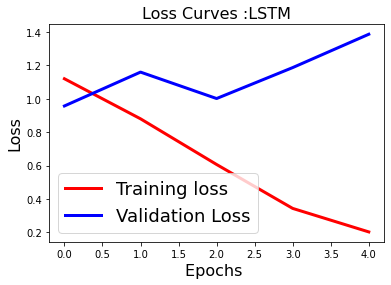

In [ ]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
%matplotlib inline

fig1 = plt.figure()
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves :LSTM',fontsize=16)
fig1.savefig('loss_lstm.png')
plt.show()

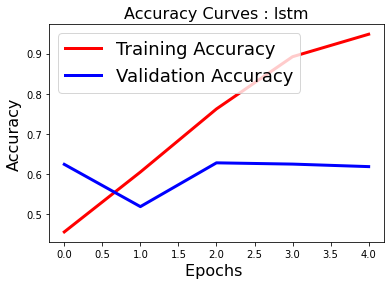

In [ ]:
fig2=plt.figure()
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves : lstm',fontsize=16)
fig2.savefig('accuracy_lstm.png')
plt.show()

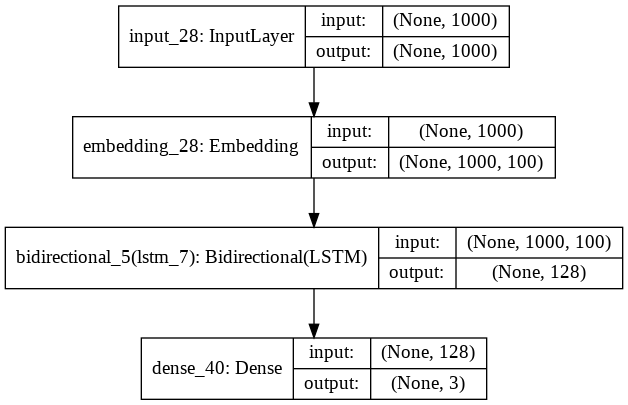

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='lstm_model.png', show_shapes=True, show_layer_names=True)

In [ ]:
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout, LSTM, GRU, Bidirectional

num_filters = 128
drop = 0.5
maxlen = MAX_SEQUENCE_LENGTH

inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)
embedding = embedding_layer(inputs)

lstm = LSTM(64)(embedding)

dense1 = Dense(256)(lstm)
dropout = Dropout(drop)(dense1)
output = Dense(units=num_classes, activation='softmax')(dropout)#,kernel_regularizer=regularizers.l2(0.01))(dropout)

model = Model(inputs, output)

model.compile(loss='categorical_crossentropy', metrics=['acc'], optimizer=adam)
callbacks = [EarlyStopping(patience=4),ModelCheckpoint('tesis_lstm_res_smotetomek.h5', monitor='val_acc', verbose=1, save_best_only=True)]

model.summary()

Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 50)                0         
_________________________________________________________________
embedding_31 (Embedding)     (None, 50, 300)           1904400   
_________________________________________________________________
lstm_6 (LSTM)                (None, 64)                93440     
_________________________________________________________________
dense_46 (Dense)             (None, 256)               16640     
_________________________________________________________________
dropout_29 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_47 (Dense)             (None, 3)                 771       
Total params: 2,015,251
Trainable params: 2,015,251
Non-trainable params: 0
________________________________________________

In [ ]:
lstm_model_res_smotetomek = model.fit(x_res, y_res, validation_data=(x_val, y_val),epochs=50, batch_size=12, callbacks=callbacks)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 7976 samples, validate on 798 samples
Epoch 1/50
7976/7976 [==============================] - 51s 6ms/step - loss: 1.0294 - acc: 0.4615 - val_loss: 0.9741 - val_acc: 0.5038

Epoch 00001: val_acc improved from -inf to 0.50376, saving model to tesis_lstm_res_smotetomek.h5
Epoch 2/50
7976/7976 [==============================] - 51s 6ms/step - loss: 0.9310 - acc: 0.5456 - val_loss: 0.8943 - val_acc: 0.6316

Epoch 00002: val_acc improved from 0.50376 to 0.63158, saving model to tesis_lstm_res_smotetomek.h5
Epoch 3/50
7976/7976 [==============================] - 51s 6ms/step - loss: 0.8165 - acc: 0.6281 - val_loss: 0.8703 - val_acc: 0.6642

Epoch 00003: val_acc improved from 0.63158 to 0.66416, saving model to tesis_lstm_res_smotetomek.h5
Epoch 4/50
7976/7976 [==============================] - 51s 6ms/step - loss: 0.7266 - acc: 0.6798 - val_loss: 1.0471 - val_acc: 0.5702

Epoch 00004: val_acc did not improve from 0.66416
Epoch 5/50
7976/7976 [==============================] - 51s 6m

In [ ]:
model_lstm_res_smotetomek = keras.models.load_model('tesis_lstm_res_smotetomek.h5')
metrics = model_lstm_res_smotetomek.evaluate(x_test, y_test)
print("{}: {}".format(model.metrics_names[0], metrics[0]))
print("{}: {}".format(model.metrics_names[1], metrics[1]))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


798/798 [==============================] - 0s 502us/step
loss: 0.8429204067191982
acc: 0.670426070690155


In [ ]:
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout, LSTM, GRU, Bidirectional

num_filters = 128
drop = 0.5
MAX_SEQUENCE_LENGTH = 1000
maxlen = MAX_SEQUENCE_LENGTH

inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)
embedding = embedding_layer(inputs)

lstm = LSTM(64)(embedding)

dense1 = Dense(256)(lstm)
dropout = Dropout(drop)(dense1)
output = Dense(units=num_classes, activation='softmax')(dropout)#,kernel_regularizer=regularizers.l2(0.01))(dropout)

model = Model(inputs, output)

model.compile(loss='categorical_crossentropy', metrics=['acc'], optimizer=adam)
callbacks = [EarlyStopping(patience=4),ModelCheckpoint('tesis_lstm_vec_unres.h5', monitor='val_acc', verbose=1, save_best_only=True)]

model.summary()

Model: "model_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        (None, 1000)              0         
_________________________________________________________________
embedding_32 (Embedding)     (None, 1000, 300)         1904400   
_________________________________________________________________
lstm_7 (LSTM)                (None, 64)                93440     
_________________________________________________________________
dense_48 (Dense)             (None, 256)               16640     
_________________________________________________________________
dropout_30 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_49 (Dense)             (None, 3)                 771       
Total params: 2,015,251
Trainable params: 2,015,251
Non-trainable params: 0
________________________________________________

In [ ]:
lstm_model_vec_unres = model.fit(x2train_vec, y2train, validation_data=(x2val_vec, y2val),epochs=50, batch_size=12, callbacks=callbacks)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 3988 samples, validate on 997 samples
Epoch 1/50
3988/3988 [==============================] - 329s 83ms/step - loss: 0.7875 - acc: 0.7197 - val_loss: 0.7675 - val_acc: 0.7252

Epoch 00001: val_acc improved from -inf to 0.72518, saving model to tesis_lstm_vec_unres.h5
Epoch 2/50
3988/3988 [==============================] - 337s 85ms/step - loss: 0.7754 - acc: 0.7252 - val_loss: 0.7647 - val_acc: 0.7252

Epoch 00002: val_acc did not improve from 0.72518
Epoch 3/50
3988/3988 [==============================] - 329s 82ms/step - loss: 0.7725 - acc: 0.7252 - val_loss: 0.7674 - val_acc: 0.7252

Epoch 00003: val_acc did not improve from 0.72518
Epoch 4/50
3988/3988 [==============================] - 328s 82ms/step - loss: 0.7710 - acc: 0.7252 - val_loss: 0.7641 - val_acc: 0.7252

Epoch 00004: val_acc did not improve from 0.72518
Epoch 5/50
3988/3988 [==============================] - 328s 82ms/step - loss: 0.7718 - acc: 0.7252 - val_loss: 0.7642 - val_acc: 0.7252

Epoch 00005: val_acc 

In [ ]:
model_lstm_vec_unres = keras.models.load_model('tesis_lstm_vec_unres.h5')
metrics = model_lstm_vec_unres.evaluate(x2test_vec, y2test)
print("{}: {}".format(model.metrics_names[0], metrics[0]))
print("{}: {}".format(model.metrics_names[1], metrics[1]))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


333/333 [==============================] - 2s 7ms/step
loss: 0.7656421271172372
acc: 0.7267267107963562


In [ ]:
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout, LSTM, GRU, Bidirectional

num_filters = 128
drop = 0.5
MAX_SEQUENCE_LENGTH = 1000
maxlen = MAX_SEQUENCE_LENGTH

inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)
embedding = embedding_layer(inputs)

lstm = LSTM(64)(embedding)

dense1 = Dense(256)(lstm)
dropout = Dropout(drop)(dense1)
output = Dense(units=num_classes, activation='softmax')(dropout)#,kernel_regularizer=regularizers.l2(0.01))(dropout)

model = Model(inputs, output)

model.compile(loss='categorical_crossentropy', metrics=['acc'], optimizer=adam)
callbacks = [EarlyStopping(patience=4),ModelCheckpoint('tesis_lstm_vec_res_smotetomek.h5', monitor='val_acc', verbose=1, save_best_only=True)]

model.summary()

Model: "model_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        (None, 1000)              0         
_________________________________________________________________
embedding_33 (Embedding)     (None, 1000, 300)         1904400   
_________________________________________________________________
lstm_8 (LSTM)                (None, 64)                93440     
_________________________________________________________________
dense_50 (Dense)             (None, 256)               16640     
_________________________________________________________________
dropout_31 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_51 (Dense)             (None, 3)                 771       
Total params: 2,015,251
Trainable params: 2,015,251
Non-trainable params: 0
________________________________________________

In [ ]:
lstm_model_vec_res_smotetomek = model.fit(x2res, y2res, validation_data=(x2val_vec, y2val),epochs=50, batch_size=12, callbacks=callbacks)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 8672 samples, validate on 997 samples
Epoch 1/50
8672/8672 [==============================] - 700s 81ms/step - loss: 1.1069 - acc: 0.3278 - val_loss: 1.0967 - val_acc: 0.1825

Epoch 00001: val_acc improved from -inf to 0.18255, saving model to tesis_lstm_vec_res_smotetomek.h5
Epoch 2/50
8672/8672 [==============================] - 700s 81ms/step - loss: 1.0998 - acc: 0.3356 - val_loss: 1.1333 - val_acc: 0.0923

Epoch 00002: val_acc did not improve from 0.18255
Epoch 3/50
8672/8672 [==============================] - 706s 81ms/step - loss: 1.1003 - acc: 0.3262 - val_loss: 1.1069 - val_acc: 0.0923

Epoch 00003: val_acc did not improve from 0.18255
Epoch 4/50
8672/8672 [==============================] - 707s 81ms/step - loss: 1.0986 - acc: 0.3402 - val_loss: 1.0882 - val_acc: 0.7252

Epoch 00004: val_acc improved from 0.18255 to 0.72518, saving model to tesis_lstm_vec_res_smotetomek.h5
Epoch 5/50
1536/8672 [====>.........................] - ETA: 9:37 - loss: 1.0994 - acc: 0.3216

KeyboardInterrupt: ignored

In [ ]:
model_lstm_vec_res_smotetomek = keras.models.load_model('tesis_lstm_vec_res_smotetomek.h5')
metrics =model_lstm_vec_res_smotetomek.evaluate(x2test_vec, y2test)
print("{}: {}".format(model.metrics_names[0], metrics[0]))
print("{}: {}".format(model.metrics_names[1], metrics[1]))

In [ ]:
MAX_SEQUENCE_LENGTH = 50

In [ ]:
drop = 0.5
maxlen = MAX_SEQUENCE_LENGTH

inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)
embedding = embedding_layer(inputs)

lstm = Bidirectional(LSTM(128))(embedding)

dense1 = Dense(256)(lstm)
dropout = Dropout(drop)(dense1)
output = Dense(units=num_classes, activation='softmax',kernel_regularizer=regularizers.l2(0.1))(dropout)

model = Model(inputs, output)

model.compile(loss='categorical_crossentropy', metrics=['acc'], optimizer=adam)
callbacks = [EarlyStopping(patience=4),ModelCheckpoint('tesis_bi_lstm_unres_2.h5', monitor='val_acc', verbose=1, save_best_only=True)]

model.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 50)                0         
_________________________________________________________________
embedding_8 (Embedding)      (None, 50, 300)           1905000   
_________________________________________________________________
bidirectional_8 (Bidirection (None, 256)               439296    
_________________________________________________________________
dense_15 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 3)                 771       
Total params: 2,410,859
Trainable params: 2,410,859
Non-trainable params: 0
_________________________________________________

In [ ]:
bi_lstm_model = model.fit(x_train, y_train, validation_data=(x_val, y_val),epochs=50, batch_size=12, callbacks=callbacks)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 3756 samples, validate on 805 samples
Epoch 1/50
3756/3756 [==============================] - 161s 43ms/step - loss: 0.7621 - acc: 0.7194 - val_loss: 0.7438 - val_acc: 0.7280

Epoch 00001: val_acc improved from -inf to 0.72795, saving model to tesis_bi_lstm_unres.h5
Epoch 2/50
3756/3756 [==============================] - 158s 42ms/step - loss: 0.7250 - acc: 0.7276 - val_loss: 0.7255 - val_acc: 0.7280

Epoch 00002: val_acc did not improve from 0.72795
Epoch 3/50
3756/3756 [==============================] - 158s 42ms/step - loss: 0.6841 - acc: 0.7338 - val_loss: 0.6833 - val_acc: 0.7416

Epoch 00003: val_acc improved from 0.72795 to 0.74161, saving model to tesis_bi_lstm_unres.h5
Epoch 4/50
3756/3756 [==============================] - 156s 42ms/step - loss: 0.6088 - acc: 0.7686 - val_loss: 0.6187 - val_acc: 0.7665

Epoch 00004: val_acc improved from 0.74161 to 0.76646, saving model to tesis_bi_lstm_unres.h5
Epoch 5/50
3756/3756 [==============================] - 157s 42ms/step -

In [ ]:
bi_lstm_model_2 = model.fit(x_train, y_train, validation_data=(x_val, y_val),epochs=50, batch_size=12, callbacks=callbacks)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 3756 samples, validate on 805 samples
Epoch 1/50
3756/3756 [==============================] - 82s 22ms/step - loss: 1.1129 - acc: 0.7220 - val_loss: 0.9524 - val_acc: 0.7280

Epoch 00001: val_acc improved from -inf to 0.72795, saving model to tesis_bi_lstm_unres_2.h5
Epoch 2/50
3756/3756 [==============================] - 82s 22ms/step - loss: 0.8451 - acc: 0.7439 - val_loss: 0.7731 - val_acc: 0.7590

Epoch 00002: val_acc improved from 0.72795 to 0.75901, saving model to tesis_bi_lstm_unres_2.h5
Epoch 3/50
3756/3756 [==============================] - 82s 22ms/step - loss: 0.6720 - acc: 0.7982 - val_loss: 0.6897 - val_acc: 0.7739

Epoch 00003: val_acc improved from 0.75901 to 0.77391, saving model to tesis_bi_lstm_unres_2.h5
Epoch 4/50
3756/3756 [==============================] - 82s 22ms/step - loss: 0.5537 - acc: 0.8187 - val_loss: 0.6648 - val_acc: 0.7801

Epoch 00004: val_acc improved from 0.77391 to 0.78012, saving model to tesis_bi_lstm_unres_2.h5
Epoch 5/50
3756/3756 [==

In [ ]:
model_bi_lstm_unres = keras.models.load_model('tesis_bi_lstm_unres_2.h5')
metrics = model_bi_lstm_unres.evaluate(x_test, y_test)
print("{}: {}".format(model.metrics_names[0], metrics[0]))
print("{}: {}".format(model.metrics_names[1], metrics[1]))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


806/806 [==============================] - 1s 1ms/step
loss: 0.705671413216934
acc: 0.770471453666687


In [ ]:
num_filters = 128
drop = 0.5
maxlen = MAX_SEQUENCE_LENGTH

inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)
embedding = embedding_layer(inputs)

lstm = Bidirectional(LSTM(64))(embedding)

dense1 = Dense(256)(lstm)
dropout = Dropout(drop)(dense1)
output = Dense(units=num_classes, activation='softmax', kernel_regularizer=regularizers.l2(0.01))(dropout)

model = Model(inputs, output)

model.compile(loss='categorical_crossentropy', metrics=['acc'], optimizer=adam)
callbacks = [EarlyStopping(patience=4),ModelCheckpoint('tesis_bi_lstm_res_smotetomek_3.h5', monitor='val_acc', verbose=1, save_best_only=True)]

model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 50)                0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 50, 300)           1905000   
_________________________________________________________________
bidirectional_7 (Bidirection (None, 128)               186880    
_________________________________________________________________
dense_13 (Dense)             (None, 256)               33024     
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 3)                 771       
Total params: 2,125,675
Trainable params: 2,125,675
Non-trainable params: 0
_________________________________________________

In [ ]:
bi_lstm_model_res_smotetomek = model.fit(x_res, y_res, validation_data=(x_val, y_val),epochs=50, batch_size=12, callbacks=callbacks)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 8145 samples, validate on 805 samples
Epoch 1/50
8145/8145 [==============================] - 180s 22ms/step - loss: 1.0752 - acc: 0.4637 - val_loss: 1.0001 - val_acc: 0.4547

Epoch 00001: val_acc improved from -inf to 0.45466, saving model to tesis_bi_lstm_res_smotetomek_3.h5
Epoch 2/50
8145/8145 [==============================] - 178s 22ms/step - loss: 0.9777 - acc: 0.5370 - val_loss: 0.9016 - val_acc: 0.6311

Epoch 00002: val_acc improved from 0.45466 to 0.63106, saving model to tesis_bi_lstm_res_smotetomek_3.h5
Epoch 3/50
8145/8145 [==============================] - 174s 21ms/step - loss: 0.8633 - acc: 0.6233 - val_loss: 0.9317 - val_acc: 0.6348

Epoch 00003: val_acc improved from 0.63106 to 0.63478, saving model to tesis_bi_lstm_res_smotetomek_3.h5
Epoch 4/50
8145/8145 [==============================] - 175s 22ms/step - loss: 0.7668 - acc: 0.6800 - val_loss: 0.8214 - val_acc: 0.6820

Epoch 00004: val_acc improved from 0.63478 to 0.68199, saving model to tesis_bi_lstm_res_

In [ ]:
bi_lstm_model_res_smotetomek_2 = model.fit(x_res, y_res, validation_data=(x_val, y_val),epochs=50, batch_size=12, callbacks=callbacks)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 8145 samples, validate on 805 samples
Epoch 1/50
8145/8145 [==============================] - 173s 21ms/step - loss: 1.0246 - acc: 0.4661 - val_loss: 0.9998 - val_acc: 0.4547

Epoch 00001: val_acc improved from -inf to 0.45466, saving model to tesis_bi_lstm_res_smotetomek_2.h5
Epoch 2/50
8145/8145 [==============================] - 175s 21ms/step - loss: 0.9218 - acc: 0.5530 - val_loss: 0.8835 - val_acc: 0.6311

Epoch 00002: val_acc improved from 0.45466 to 0.63106, saving model to tesis_bi_lstm_res_smotetomek_2.h5
Epoch 3/50
8145/8145 [==============================] - 176s 22ms/step - loss: 0.8066 - acc: 0.6350 - val_loss: 0.7447 - val_acc: 0.7068

Epoch 00003: val_acc improved from 0.63106 to 0.70683, saving model to tesis_bi_lstm_res_smotetomek_2.h5
Epoch 4/50
8145/8145 [==============================] - 179s 22ms/step - loss: 0.7141 - acc: 0.6885 - val_loss: 0.7432 - val_acc: 0.7068

Epoch 00004: val_acc did not improve from 0.70683
Epoch 5/50
8145/8145 [=================

In [ ]:
model_bi_lstm_res_smotetomek = keras.models.load_model('tesis_bi_lstm_res_smotetomek_2.h5')
metrics = model_bi_lstm_res_smotetomek.evaluate(x_test, y_test)
print("{}: {}".format(model.metrics_names[0], metrics[0]))
print("{}: {}".format(model.metrics_names[1], metrics[1]))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


806/806 [==============================] - 1s 1ms/step
loss: 0.7665903445508876
acc: 0.7034739255905151


### **CNN LSTM**

In [ ]:
pip install keras-self-attention

  Created wheel for keras-self-attention: filename=keras_self_attention-0.46.0-cp36-none-any.whl size=17278 sha256=1f775888026d2157a966503a3e30374057d5e189932aad5c6e185204c910a33d
  Stored in directory: /root/.cache/pip/wheels/d2/2e/80/fec4c05eb23c8e13b790e26d207d6e0ffe8013fad8c6bdd4d2
Successfully built keras-self-attention


In [ ]:
from keras_self_attention import SeqSelfAttention

##### CNN LSTM

In [ ]:
maxlen = MAX_SEQUENCE_LENGTH
#maxlen_vec = td
num_filters = 128
border_mode = 'same'
filter_length = 5
dropout_rate = 0.5
lstm_cell = 128
fc_cell = 128
pool_length = 2
kernel_sizes = [1,2,3]


inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            trainable=True)
embedding = embedding_layer(inputs)

#emb2 = Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], 
#                 weights=[embedding_matrix], trainable=True)(inputs)

s_drop = SpatialDropout1D(dropout_rate)(embedding)
#conv = Conv1D(num_filters, kernel_size=filter_length, activation = 'relu')(s_drop) #padding=border_mode,
#conv = BatchNormalization()(conv)
#maxpool = MaxPooling1D(pool_size=pool_length)(conv)

conv_0 = Conv1D(num_filters, kernel_sizes[0], padding=border_mode, activation = 'relu')(s_drop) #padding=border_mode,
conv_0 = BatchNormalization()(conv_0)
maxpool_0 = MaxPooling1D(pool_size = (maxlen - kernel_sizes[0] + 1), strides=1, padding='valid')(conv_0)
    
conv_1 = Conv1D(num_filters, kernel_sizes[1], padding=border_mode, activation = 'relu')(s_drop) #padding=border_mode,
conv_1 = BatchNormalization()(conv_1)
maxpool_1 = MaxPooling1D(pool_size = (maxlen - kernel_sizes[1] + 1), strides=1, padding='valid')(conv_1)
    
conv_2 = Conv1D(num_filters, kernel_sizes[2], padding=border_mode, activation = 'relu')(s_drop) #padding=border_mode,
conv_2 = BatchNormalization()(conv_2)
maxpool_2 = MaxPooling1D(pool_size = (maxlen - kernel_sizes[2] + 1), strides=1, padding='valid')(conv_2)
    
merged = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2])
lstm = LSTM((lstm_cell), return_sequences=True)(merged)
seq = SeqSelfAttention(units=lstm_cell)(lstm)
flatten = Flatten()(seq)


#dense1 = Dense(fc_cell*2)(flatten)
#lstm = Bidirectional(LSTM((lstm_cell), return_sequences=False))(dense1)
drop = Dropout(dropout_rate)(flatten)
output = Dense(units=num_classes, activation='softmax')(drop)


model_cnn_lstm_unres = Model(inputs, output)
model_cnn_lstm_res = Model(inputs, output)

model_cnn_lstm_unres.compile(loss='categorical_crossentropy', optimizer=rmsprop, metrics=['acc', f1])
model_cnn_lstm_res.compile(loss='categorical_crossentropy', optimizer=rmsprop, metrics=['acc', f1])

callbacks_unres = [EarlyStopping(monitor='val_loss', verbose= 1, patience=10, mode='auto'), 
                   ModelCheckpoint('/content/drive/My Drive/Tesis/Hasil NN Tesis/CNN LSTM/tesis_model_cnn_lstm_unres2.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto'), 
                   ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.001)]

callbacks_res = [EarlyStopping(monitor='val_loss', verbose= 1, patience=10, mode='auto'), 
                 ModelCheckpoint('/content/drive/My Drive/Tesis/Hasil NN Tesis/CNN LSTM/tesis_model_cnn_lstm_res2.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto'), 
                 ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.001)]

print('Model CNN LSTM UNRES')
model_cnn_lstm_unres.summary()
print('Model CNN LSTM RES')
model_cnn_lstm_res.summary()

Model CNN LSTM UNRES
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 50, 300)      1905000     input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 50, 300)      0           embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 50, 128)      38528       spatial_dropout1d_1[0][0]        
_______________________________________________________________________

In [ ]:
tesis_model_cnn_lstm_unres = model_cnn_lstm_unres.fit(x_train, y_train, batch_size=12, epochs=50,
                                            validation_data=(x_val, y_val), callbacks=callbacks_unres, shuffle=True, verbose=1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 3756 samples, validate on 805 samples
Epoch 1/50
3756/3756 [==============================] - 36s 10ms/step - loss: 0.7695 - acc: 0.7181 - f1: 0.6997 - val_loss: 1.0481 - val_acc: 0.7280 - val_f1: 0.7316

Epoch 00001: val_loss improved from inf to 1.04806, saving model to /content/drive/My Drive/Tesis/Hasil NN Tesis/CNN LSTM/tesis_model_cnn_lstm_unres2.h5
Epoch 2/50
3756/3756 [==============================] - 35s 9ms/step - loss: 0.6441 - acc: 0.7716 - f1: 0.7605 - val_loss: 0.6568 - val_acc: 0.8000 - val_f1: 0.8028

Epoch 00002: val_loss improved from 1.04806 to 0.65680, saving model to /content/drive/My Drive/Tesis/Hasil NN Tesis/CNN LSTM/tesis_model_cnn_lstm_unres2.h5
Epoch 3/50
3756/3756 [==============================] - 37s 10ms/step - loss: 0.5661 - acc: 0.7854 - f1: 0.7801 - val_loss: 0.5902 - val_acc: 0.8062 - val_f1: 0.8119

Epoch 00003: val_loss improved from 0.65680 to 0.59016, saving model to /content/drive/My Drive/Tesis/Hasil NN Tesis/CNN LSTM/tesis_model_cnn_l

In [ ]:
tesis_model_cnn_lstm_res = model_cnn_lstm_res.fit(x_res, y_res, batch_size=12, epochs=50,
                                            validation_data=(x_val, y_val), callbacks=callbacks_res, shuffle=True, verbose=1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 8145 samples, validate on 805 samples
Epoch 1/100
8145/8145 [==============================] - 60s 7ms/step - loss: 1.0399 - acc: 0.4438 - f1: 0.2704 - val_loss: 0.9995 - val_acc: 0.4758 - val_f1: 0.4275

Epoch 00001: val_loss improved from inf to 0.99953, saving model to /content/drive/My Drive/Tesis/Hasil NN Tesis/CNN LSTM/tesis_model_cnn_lstm_res.h5
Epoch 2/100
8145/8145 [==============================] - 60s 7ms/step - loss: 0.9619 - acc: 0.5012 - f1: 0.3819 - val_loss: 0.9528 - val_acc: 0.5739 - val_f1: 0.4925

Epoch 00002: val_loss improved from 0.99953 to 0.95285, saving model to /content/drive/My Drive/Tesis/Hasil NN Tesis/CNN LSTM/tesis_model_cnn_lstm_res.h5
Epoch 3/100
8145/8145 [==============================] - 61s 8ms/step - loss: 0.9153 - acc: 0.5405 - f1: 0.4550 - val_loss: 0.7605 - val_acc: 0.7093 - val_f1: 0.6892

Epoch 00003: val_loss improved from 0.95285 to 0.76047, saving model to /content/drive/My Drive/Tesis/Hasil NN Tesis/CNN LSTM/tesis_model_cnn_lstm_r

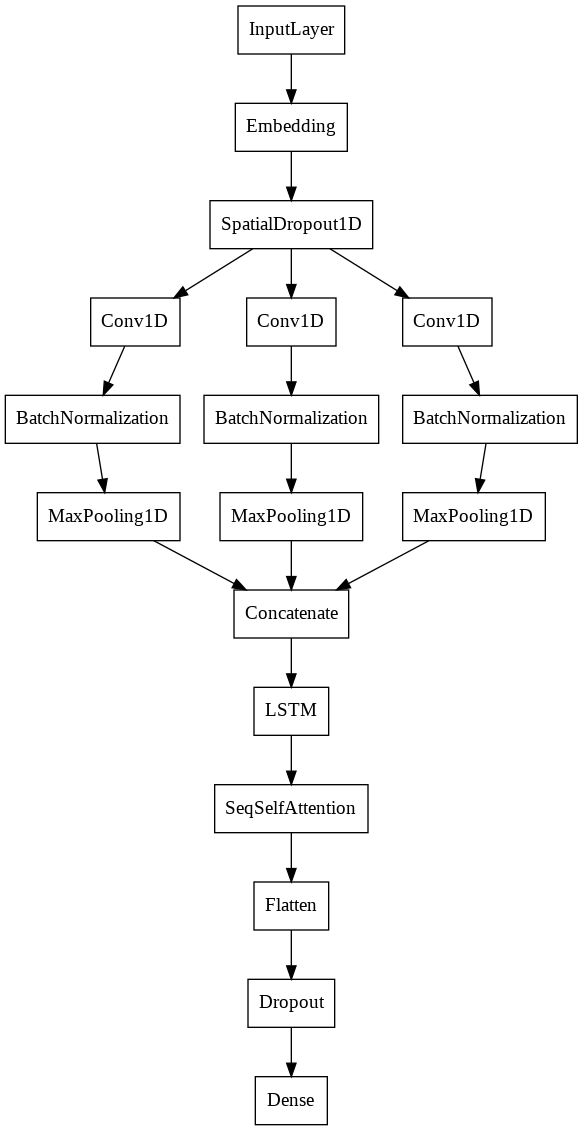

In [ ]:
plot_model(model_cnn_lstm_unres, to_file='/content/drive/My Drive/Tesis/Hasil NN Tesis/CNN LSTM/tesis_model_cnn_lstm_unres3.png', 
           show_shapes=False, show_layer_names=False)

In [ ]:
maxlen = MAX_SEQUENCE_LENGTH
maxlen_vec = td
num_filters = 128
border_mode = 'same'
filter_length = 3
dropout_rate = 0.5
lstm_cell = 128
fc_cell = 128
pool_length = 2


inputs = Input(shape=(maxlen_vec,))
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            trainable=True)
#embedding = embedding_layer(inputs)

emb2 = Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], 
                 weights=[embedding_matrix], trainable=True)(inputs)

s_drop = SpatialDropout1D(dropout_rate)(emb2)
conv = Conv1D(num_filters, kernel_size=filter_length, padding=border_mode, activation = 'relu')(s_drop)
conv = BatchNormalization()(conv)
maxpool = MaxPooling1D(pool_size=pool_length)(conv)

lstm = LSTM((lstm_cell), return_sequences=False)(maxpool)
dense1 = Dense(fc_cell*2)(lstm)
drop = Dropout(dropout_rate)(dense1)
output = Dense(units=num_classes, activation='softmax')(drop)


model_cnn_lstm_unres_vec = Model(inputs, output)
model_cnn_lstm_res_vec = Model(inputs, output)

model_cnn_lstm_unres_vec.compile(loss='categorical_crossentropy', optimizer=rmsprop, metrics=['acc', f1])
model_cnn_lstm_res_vec.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['acc', f1])

callbacks_unres_vec = [EarlyStopping(monitor='val_loss', verbose= 1, patience=10, mode='auto'), 
                   ModelCheckpoint('/content/drive/My Drive/Tesis/Hasil NN Tesis/CNN LSTM/tesis_model_cnn_lstm_unres_vec.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto'), 
                   ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.001)]

callbacks_res_vec = [EarlyStopping(monitor='val_loss', verbose= 1, patience=10, mode='auto'), 
                 ModelCheckpoint('/content/drive/My Drive/Tesis/Hasil NN Tesis/CNN LSTM/tesis_model_cnn_lstm_res_vec.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto'), 
                 ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.001)]

print('Model CNN LSTM UNRES VEC')
model_cnn_lstm_unres_vec.summary()
print('Model CNN LSTM RES VEC')
model_cnn_lstm_res_vec.summary()

In [ ]:
tesis_model_cnn_lstm_unres_vec = model_cnn_lstm_unres_vec.fit(x2train_vec, y2train, batch_size=32, epochs=100, 
                                                    validation_data=(x2val_vec, y2val), callbacks=callbacks_unres_vec, shuffle=True, verbose=1)

In [ ]:
tesis_model_cnn_lstm_res_vec = model_cnn_lstm_res_vec.fit(x2res, y2res, batch_size=32, epochs=100, 
                                                    validation_data=(x2val_vec, y2val), callbacks=callbacks_res_vec, shuffle=True, verbose=1)

##### CNN BiLSTM

In [ ]:
maxlen = MAX_SEQUENCE_LENGTH
#maxlen_vec = td
num_filters = 128
border_mode = 'same'
filter_length = 5
dropout_rate = 0.5
lstm_cell = 128
fc_cell = 128
pool_length = 2
kernel_sizes = [5,5,5]


inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            trainable=True)
embedding = embedding_layer(inputs)

#emb2 = Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], 
#                 weights=[embedding_matrix], trainable=True)(inputs)

s_drop = SpatialDropout1D(dropout_rate)(embedding)
#conv = Conv1D(num_filters, kernel_size=filter_length, activation = 'relu')(s_drop) #padding=border_mode,
#conv = BatchNormalization()(conv)
#maxpool = MaxPooling1D(pool_size=pool_length)(conv)



conv = Conv1D(num_filters, kernel_sizes[0], padding=border_mode, activation = 'relu')(s_drop) #padding=border_mode,
conv = BatchNormalization()(conv)
maxpool = MaxPooling1D(pool_size = (maxlen - kernel_sizes[0] + 1), strides=1, padding='valid')(conv)
    
conv = Conv1D(num_filters, kernel_sizes[1], padding=border_mode, activation = 'relu')(s_drop) #padding=border_mode,
conv = BatchNormalization()(conv)
maxpool = MaxPooling1D(pool_size = (maxlen - kernel_sizes[1] + 1), strides=1, padding='valid')(conv)
    
conv = Conv1D(num_filters, kernel_sizes[2], padding=border_mode, activation = 'relu')(s_drop) #padding=border_mode,
conv = BatchNormalization()(conv)
maxpool = MaxPooling1D(pool_size = (maxlen - kernel_sizes[2] + 1), strides=1, padding='valid')(conv)
    
#merged = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2])
lstm = Bidirectional(LSTM((lstm_cell), return_sequences=True))(conv)
seq = SeqSelfAttention(units=lstm_cell)(lstm)
flatten = Flatten()(seq)


dense1 = Dense(fc_cell*2)(flatten)
#lstm = Bidirectional(LSTM((lstm_cell), return_sequences=False))(dense1)
drop = Dropout(dropout_rate)(dense1)
output = Dense(units=num_classes, activation='softmax')(drop)


model_cnn_bilstm_unres = Model(inputs, output)
model_cnn_bilstm_res = Model(inputs, output)

model_cnn_bilstm_unres.compile(loss='categorical_crossentropy', optimizer=rmsprop, metrics=['acc', f1])
model_cnn_bilstm_res.compile(loss='categorical_crossentropy', optimizer=rmsprop, metrics=['acc', f1])

callbacks_unres = [EarlyStopping(monitor='val_loss', verbose= 1, patience=10, mode='auto'), 
                   ModelCheckpoint('/content/drive/My Drive/Tesis/Hasil NN Tesis/CNN LSTM/tesis_model_cnn_bilstm_unres.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto'), 
                   ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.001)]

callbacks_res = [EarlyStopping(monitor='val_loss', verbose= 1, patience=10, mode='auto'), 
                 ModelCheckpoint('/content/drive/My Drive/Tesis/Hasil NN Tesis/CNN LSTM/tesis_model_cnn_bilstm_res.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto'), 
                 ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.001)]

print('Model CNN BiLSTM UNRES')
model_cnn_lstm_unres.summary()
print('Model CNN BiLSTM RES')
model_cnn_lstm_res.summary()

Model CNN BiLSTM UNRES
Model: "model_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 50)                0         
_________________________________________________________________
embedding_21 (Embedding)     (None, 50, 300)           1905000   
_________________________________________________________________
spatial_dropout1d_15 (Spatia (None, 50, 300)           0         
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 50, 128)           192128    
_________________________________________________________________
batch_normalization_43 (Batc (None, 50, 128)           512       
_________________________________________________________________
lstm_22 (LSTM)               (None, 50, 128)           131584    
_________________________________________________________________
seq_self_attention_3 (SeqSel (None,

In [ ]:
tesis_model_cnn_bilstm_unres = model_cnn_bilstm_unres.fit(x_train, y_train, batch_size=12, epochs=100, 
                                                      validation_data=(x_val, y_val), callbacks=callbacks_unres, shuffle=True, verbose=1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 3756 samples, validate on 805 samples
Epoch 1/100
3756/3756 [==============================] - 88s 23ms/step - loss: 2.1310 - acc: 0.6368 - f1: 0.6171 - val_loss: 0.7634 - val_acc: 0.7280 - val_f1: 0.6823

Epoch 00001: val_loss improved from inf to 0.76337, saving model to /content/drive/My Drive/Tesis/Hasil NN Tesis/CNN LSTM/tesis_model_cnn_bilstm_unres.h5
Epoch 2/100
3756/3756 [==============================] - 87s 23ms/step - loss: 0.7195 - acc: 0.7441 - f1: 0.7359 - val_loss: 0.6571 - val_acc: 0.7478 - val_f1: 0.7487

Epoch 00002: val_loss improved from 0.76337 to 0.65709, saving model to /content/drive/My Drive/Tesis/Hasil NN Tesis/CNN LSTM/tesis_model_cnn_bilstm_unres.h5
Epoch 3/100
3756/3756 [==============================] - 86s 23ms/step - loss: 0.6329 - acc: 0.7766 - f1: 0.7731 - val_loss: 0.5987 - val_acc: 0.7851 - val_f1: 0.7732

Epoch 00003: val_loss improved from 0.65709 to 0.59869, saving model to /content/drive/My Drive/Tesis/Hasil NN Tesis/CNN LSTM/tesis_model

In [ ]:
tesis_model_cnn_bilstm_res = model_cnn_bilstm_res.fit(x_res, y_res, batch_size=12, epochs=100,
                                            validation_data=(x_val, y_val), callbacks=callbacks_res, shuffle=True, verbose=1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 8145 samples, validate on 805 samples
Epoch 1/100
8145/8145 [==============================] - 162s 20ms/step - loss: 0.9439 - acc: 0.5538 - f1: 0.4712 - val_loss: 0.9141 - val_acc: 0.6497 - val_f1: 0.5568

Epoch 00001: val_loss improved from inf to 0.91406, saving model to /content/drive/My Drive/Tesis/Hasil NN Tesis/CNN LSTM/tesis_model_cnn_bilstm_res.h5
Epoch 2/100
8145/8145 [==============================] - 161s 20ms/step - loss: 0.8536 - acc: 0.6106 - f1: 0.5589 - val_loss: 0.8099 - val_acc: 0.7230 - val_f1: 0.6608

Epoch 00002: val_loss improved from 0.91406 to 0.80994, saving model to /content/drive/My Drive/Tesis/Hasil NN Tesis/CNN LSTM/tesis_model_cnn_bilstm_res.h5
Epoch 3/100
8145/8145 [==============================] - 161s 20ms/step - loss: 0.7958 - acc: 0.6394 - f1: 0.6035 - val_loss: 0.8067 - val_acc: 0.7006 - val_f1: 0.6557

Epoch 00003: val_loss improved from 0.80994 to 0.80672, saving model to /content/drive/My Drive/Tesis/Hasil NN Tesis/CNN LSTM/tesis_model_

##### CNN LSTM TEST

In [ ]:
filter_sizes = [1,2,3]
num_filters = 128
drop = 0.25
maxlen = MAX_SEQUENCE_LENGTH

inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)
embedding = embedding_layer(inputs)

s_drop = SpatialDropout1D(drop)(embedding)
conv_0 = Conv1D(num_filters, filter_sizes[0], activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(s_drop)
conv_0 = BatchNormalization()(conv_0)
conv_1 = Conv1D(num_filters, filter_sizes[1], activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(s_drop)
conv_1 = BatchNormalization()(conv_1)
conv_2 = Conv1D(num_filters, filter_sizes[2], activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(s_drop)
conv_2 = BatchNormalization()(conv_2)

maxpool_0 = MaxPooling1D(maxlen - filter_sizes[0] + 1, strides=1, padding='valid')(conv_0)
maxpool_1 = MaxPooling1D(maxlen - filter_sizes[1] + 1, strides=1, padding='valid')(conv_1)
maxpool_2 = MaxPooling1D(maxlen - filter_sizes[2] + 1, strides=1, padding='valid')(conv_2)

merged_tensor = concatenate([maxpool_0, maxpool_1, maxpool_2], axis=1)

l_lstm = LSTM(256, return_sequences=True)(merged_tensor)
seq = SeqSelfAttention(256)(l_lstm)

flatten = Flatten()(seq)

#dense1 = Dense(256, activation='relu')(flatten)
#dropout = Dropout(drop)(dense1)
#dense2 =  Dense(1)(dropout)

#flatten = Flatten()(merged_tensor)
#l_lstm = Bidirectional(LSTM(128))(merged_tensor)


dense1 = Dense(256)(flatten)
dropout = Dropout(drop)(dense1)
#l_lstm = Bidirectional(LSTM(256, return_sequences=True))(dropout)
#seq = SeqSelfAttention(256)(l_lstm)
#flatten = Flatten()(seq)
output = Dense(units=num_classes, activation='softmax',kernel_regularizer=regularizers.l2(0.01))(dropout)

model = Model(inputs, output)

model.compile(loss='categorical_crossentropy', metrics=['acc', f1], optimizer=rmsprop)  #optimizer='rmsprop'
callbacks = [ModelCheckpoint('tesis_cnn_bi_lstm.h5', monitor='val_loss', verbose=2, save_best_only=True)]

model.summary()

Model: "model_35"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_32 (InputLayer)           (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_32 (Embedding)        (None, 50, 300)      1905000     input_32[0][0]                   
__________________________________________________________________________________________________
spatial_dropout1d_21 (SpatialDr (None, 50, 300)      0           embedding_32[0][0]               
__________________________________________________________________________________________________
conv1d_85 (Conv1D)              (None, 50, 128)      38528       spatial_dropout1d_21[0][0]       
___________________________________________________________________________________________

In [ ]:
historylstm=model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=50, batch_size=12, shuffle=True, callbacks=callbacks) #validation_split=0.25validation_data=(x_test, y_test)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 3756 samples, validate on 805 samples
Epoch 1/50
3756/3756 [==============================] - 26s 7ms/step - loss: 2.1149 - acc: 0.7391 - f1: 0.7268 - val_loss: 0.9970 - val_acc: 0.7876 - val_f1: 0.7789

Epoch 00001: val_loss improved from inf to 0.99699, saving model to tesis_cnn_bi_lstm.h5
Epoch 2/50
3756/3756 [==============================] - 24s 7ms/step - loss: 0.7701 - acc: 0.7958 - f1: 0.7926 - val_loss: 1.1467 - val_acc: 0.4708 - val_f1: 0.4190

Epoch 00002: val_loss did not improve from 0.99699
Epoch 3/50
3756/3756 [==============================] - 24s 7ms/step - loss: 0.5958 - acc: 0.8261 - f1: 0.8241 - val_loss: 11.8059 - val_acc: 0.0919 - val_f1: 0.0907

Epoch 00003: val_loss did not improve from 0.99699
Epoch 4/50
3756/3756 [==============================] - 24s 6ms/step - loss: 0.5318 - acc: 0.8525 - f1: 0.8479 - val_loss: 0.6921 - val_acc: 0.7752 - val_f1: 0.7640

Epoch 00004: val_loss improved from 0.99699 to 0.69215, saving model to tesis_cnn_bi_lstm.h5
Epoc

KeyboardInterrupt: ignored

In [ ]:
cnn_bi_lstm_model = keras.models.load_model('tesis_cnn_bi_lstm.h5')
metrics = cnn_bi_lstm_model.evaluate(x_test, y_test)
print("{}: {}".format(model.metrics_names[0], metrics[0]))
print("{}: {}".format(model.metrics_names[1], metrics[1]))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


1596/1596 [==============================] - 5s 3ms/step
loss: 0.7257004883653837
acc: 0.7280701994895935


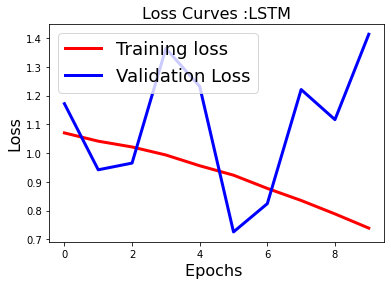

In [ ]:
plt.switch_backend('agg')
%matplotlib inline

fig1 = plt.figure()
plt.plot(historylstm.history['loss'],'r',linewidth=3.0)
plt.plot(historylstm.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves :LSTM',fontsize=16)
fig1.savefig('loss_cnn_bi_lstm.png')
plt.show()

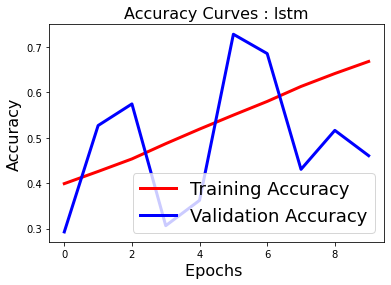

In [ ]:
fig2=plt.figure()
plt.plot(historylstm.history['acc'],'r',linewidth=3.0)
plt.plot(historylstm.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves : lstm',fontsize=16)
fig2.savefig('accuracy_cnn_bi_lstm.png')
plt.show()

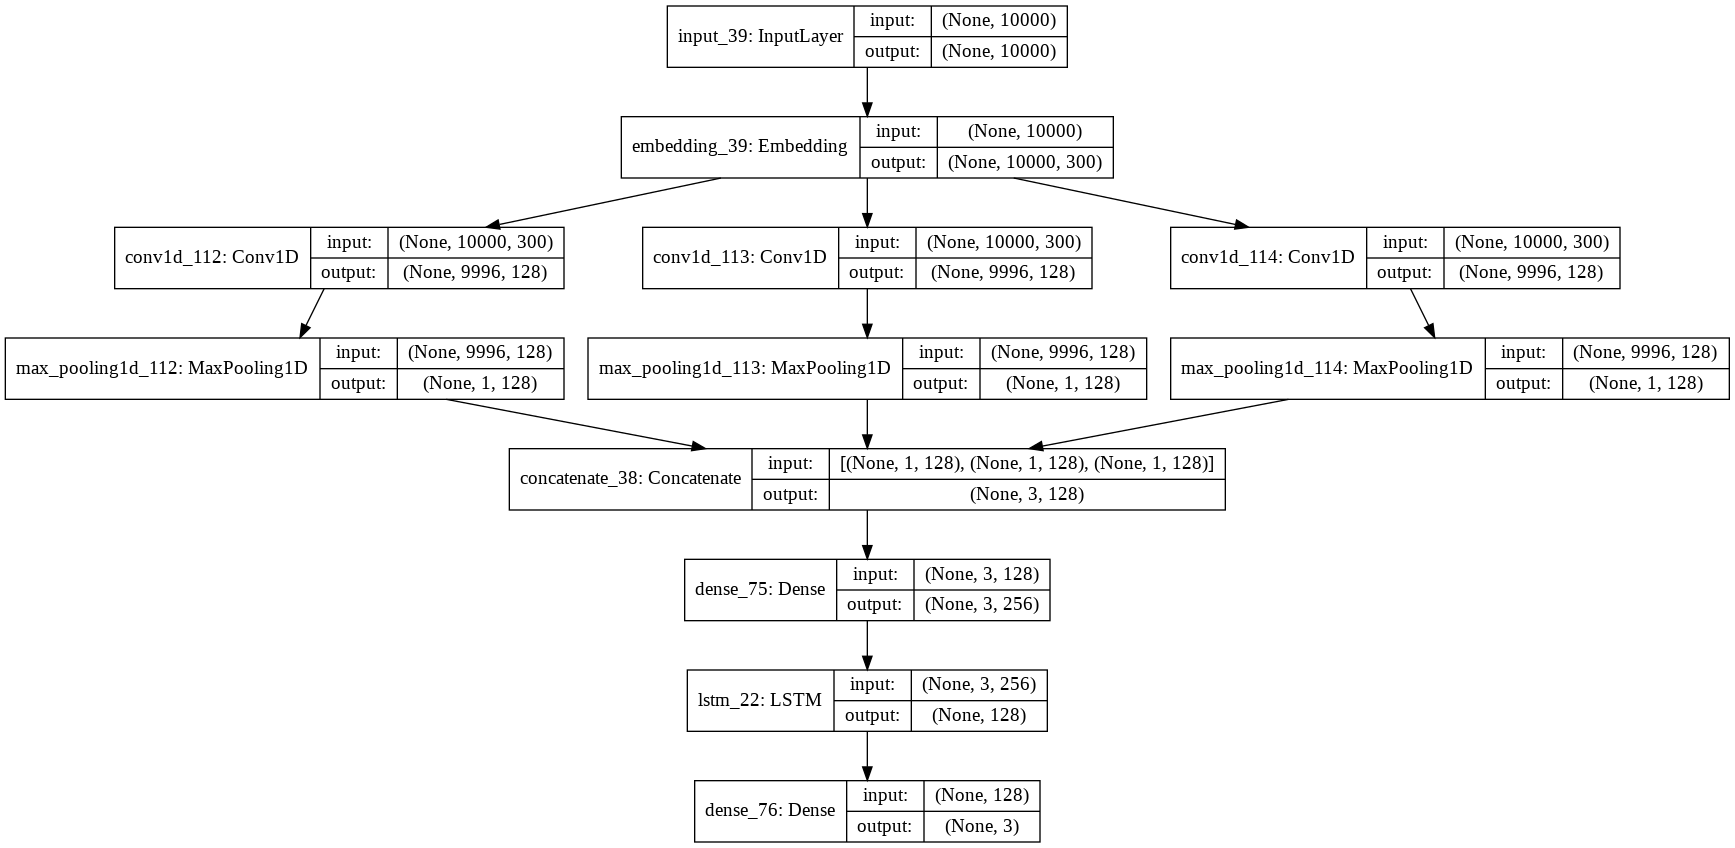

In [ ]:
plot_model(model, to_file='cnn_bi_lstm_model.png', show_shapes=True, show_layer_names=True)

In [ ]:
from keras.layers import Dense, Activation, Embedding, Flatten, GlobalMaxPool1D, Dropout, Conv1D


filter_length = 128

model = Sequential()
model.add(Embedding(5000, 20, input_length=1000))
model.add(Dropout(0.5))
model.add(Conv1D(filter_length, 3, padding='valid', activation='relu', strides=1))
model.add(GlobalMaxPool1D())
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
callbacks = [EarlyStopping(patience=4),ModelCheckpoint('tesistestcnn.h5', monitor='val_acc', verbose=1, save_best_only=True)]
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_56 (Embedding)     (None, 1000, 20)          100000    
_________________________________________________________________
dropout_46 (Dropout)         (None, 1000, 20)          0         
_________________________________________________________________
conv1d_94 (Conv1D)           (None, 998, 128)          7808      
_________________________________________________________________
global_max_pooling1d_8 (Glob (None, 128)               0         
_________________________________________________________________
dense_81 (Dense)             (None, 3)                 387       
_________________________________________________________________
activation_8 (Activation)    (None, 3)                 0         
Total params: 108,195
Trainable params: 108,195
Non-trainable params: 0
_______________________________________________